## Primer Taller Fundamentos de Análitica II
### Presentado por
- Freddy Mauricio Gutierrez. 
- Laura Loaiza Palacio 

### Contexto de negocio.
Una empresa aseguradora en salud está presentando altos costos dados por complicaciones de pacientes que anteriormente habían sido marcados con ciertas enfermedades, cuya complicación puede aumentar tanto el costo (en casi 15 veces) como la preocupación del paciente. La primera enfermedad que han decidido estudiar estratégicamente es la Hipertensión Arterial (HTA). Dado esto, la empresa requiere mantener un control de estos pacientes, haciendo demanda inducida, seguimiento periódico, adopción de estrategias médicas, entre otras, que permitan evitar que se llegue a alguna complicación. Realizar esto para más de 200.000 pacientes identificados con esta enfermedad es algo muy costoso, es entonces necesario priorizarlos tratando de predecir cuáles serían los pacientes que llegarán a presentar alguna complicación en los siguientes 6 meses.

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
#from dython.nominal import associations
from sklearn import preprocessing
from sklearn.decomposition import PCA
from dataprep.eda import create_report
import numpy as np
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from catboost import Pool
import xgboost as xgb
from hyperopt import fmin, tpe, hp
from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
df = pd.read_parquet("df_train.parquet")

Las variables: 'FUMADOR' y 'EXFUMADOR' sólo tienen valores de 0 o valores nulos, por lo tanto, no aportan información valiosa a nuestro modelo y serán eliminadas del dataset.

In [3]:
df =df.drop('FUMADOR', axis=1)
df=df.drop('EXFUMADOR', axis=1)

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Target'])  
y = df['Target']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


##  Análisis del Baseline 

In [5]:
baseline_classifier = DummyClassifier(strategy="most_frequent")

baseline_classifier.fit(X_train, y_train)

y_pred_baseline = baseline_classifier.predict(X_test)

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print("Accuracy del Baseline:", accuracy_baseline)


Accuracy del Baseline: 0.9567530497308755


Para el baseline se obtuvo un accuracy de 0.95675304973

## Tratamiento de los Datos. 
### Conversión de tipo de variables, descripción de las variables categoricas y numéricas. 

In [6]:


class PipelineDatos:
    def __init__(self, dataset):
        self.dataset = dataset

    def convertir_columnas(self):
        self.dataset["Target"] = self.dataset["Target"].astype(object)
        self.dataset["TSISTOLICA"] = self.dataset["TSISTOLICA"].astype(float)
        self.dataset["TDIASTOLICA"] = self.dataset["TDIASTOLICA"].astype(float)
        self.dataset['TipoAfiliado'] = self.dataset['TipoAfiliado'].replace(np.nan, 'Falta Descripción Estado Afiliado')

    def descriptivas(self):
        num_cols = self.dataset.select_dtypes(include='number')
        cat_cols = self.dataset.select_dtypes(exclude='number')

        for col in num_cols.columns:
            plt.figure(figsize=(8, 6))
            plt.title(f'Box Plot para {col}')
            plt.boxplot(self.dataset[col])
            plt.xlabel(col)
            plt.ylabel('Valor')
            plt.show()

        for col in cat_cols.columns:
            plt.figure(figsize=(8, 6))
            plt.title(f'Bar Plot para {col}')
            cat_counts = self.dataset[col].value_counts()
            cat_counts.plot(kind='bar')
            plt.xlabel(col)
            plt.ylabel('Frecuencia')
            plt.show()

    def convertir_fecha_a_datetime(self):
        date_columns = [col for col in self.dataset.columns if 'FECHA' in col]
        for col in date_columns:
            self.dataset[col] = pd.to_datetime(self.dataset[col], errors='coerce', format='%Y-%m-%d')

    def procesar_columnas(self):
        data = self.dataset.copy()
        selected_columns = data.iloc[:, 20:54]
        for col in selected_columns.columns:
            if not pd.api.types.is_datetime64_any_dtype(selected_columns[col]):
                selected_columns[col].fillna(0, inplace=True)
        data.iloc[:, 20:54] = selected_columns
        return data


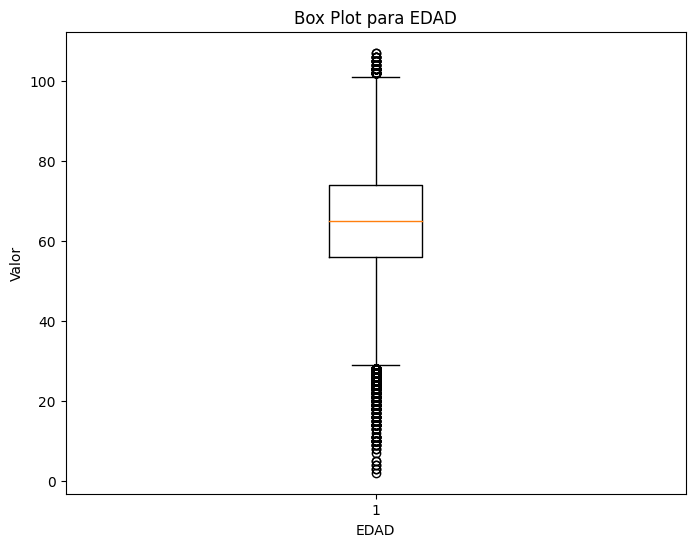

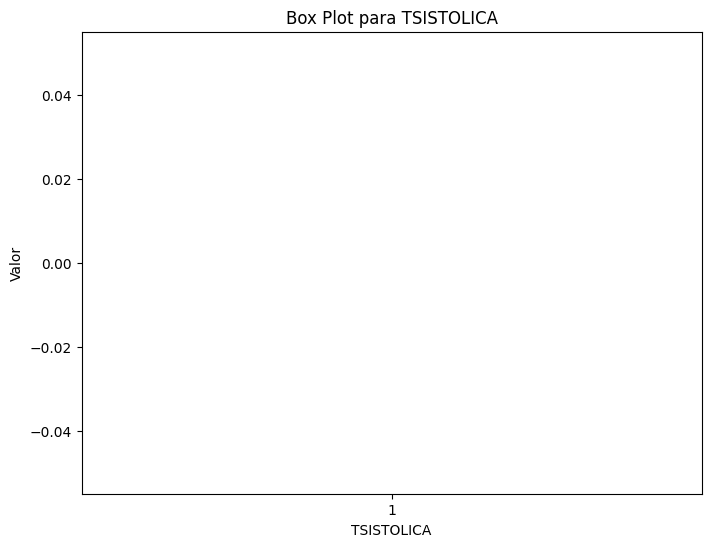

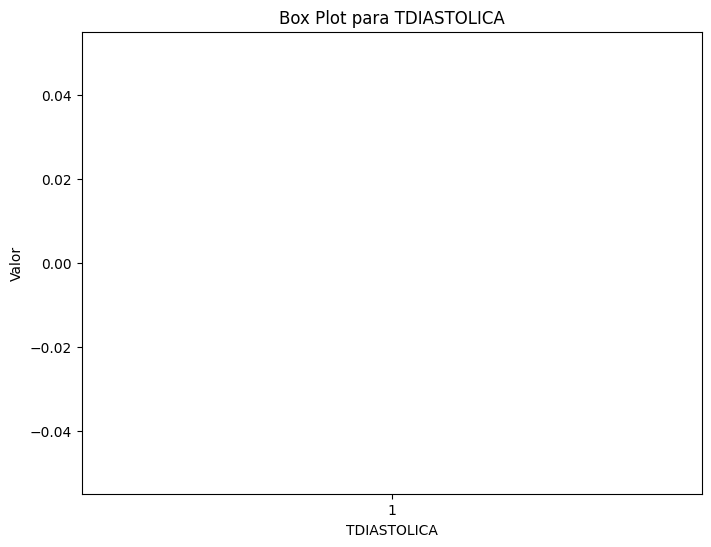

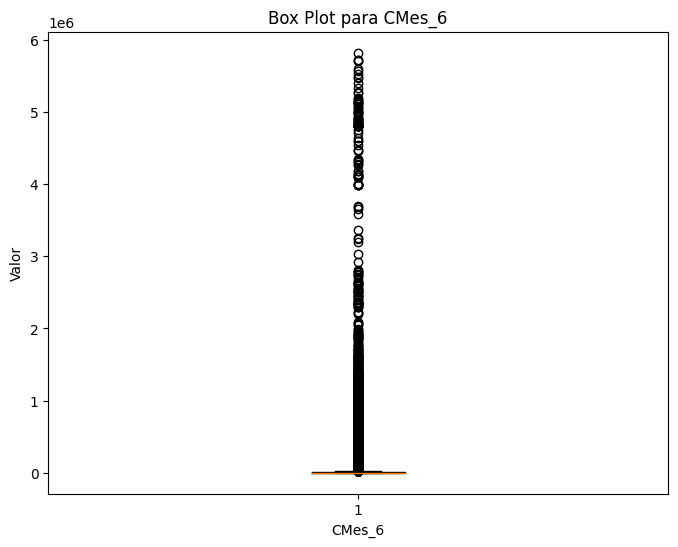

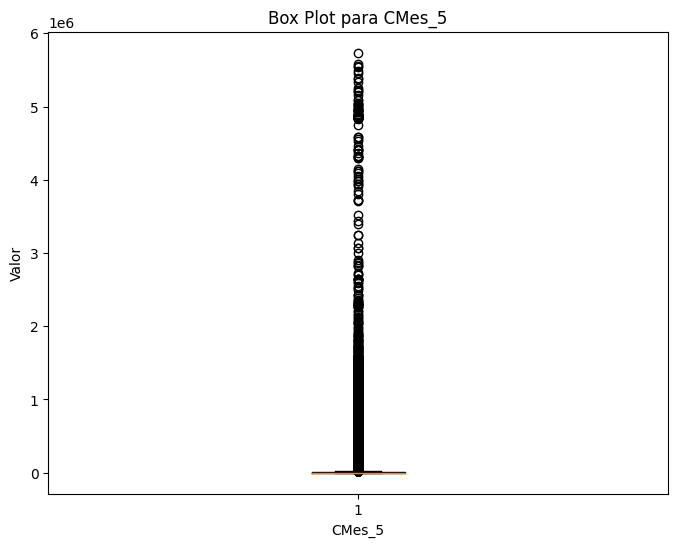

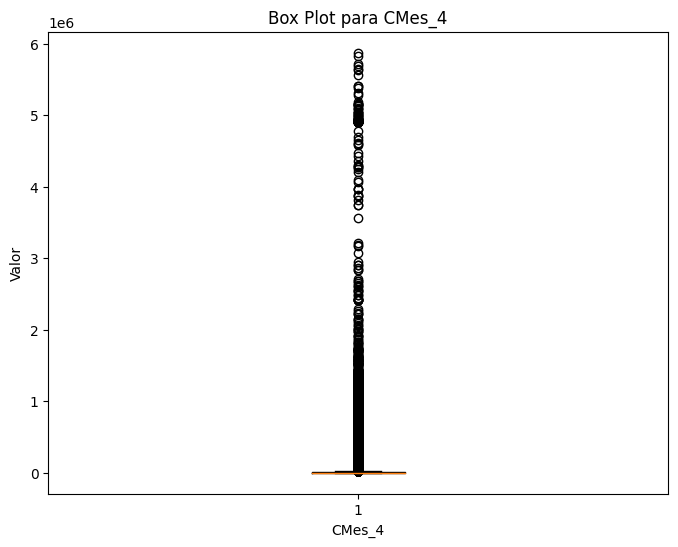

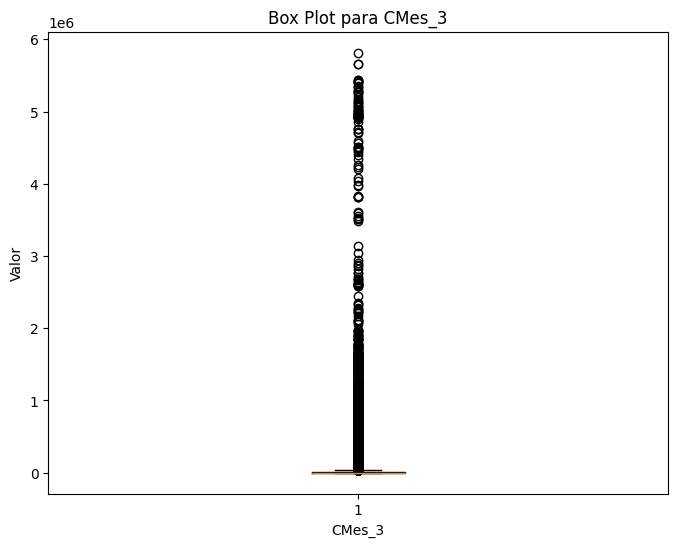

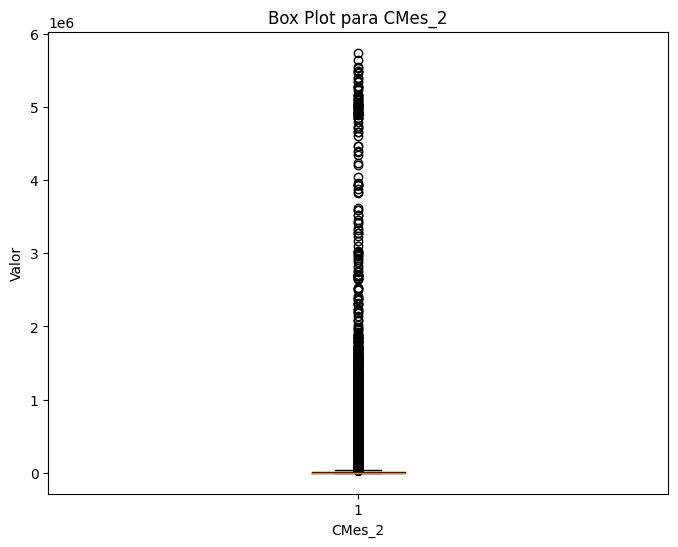

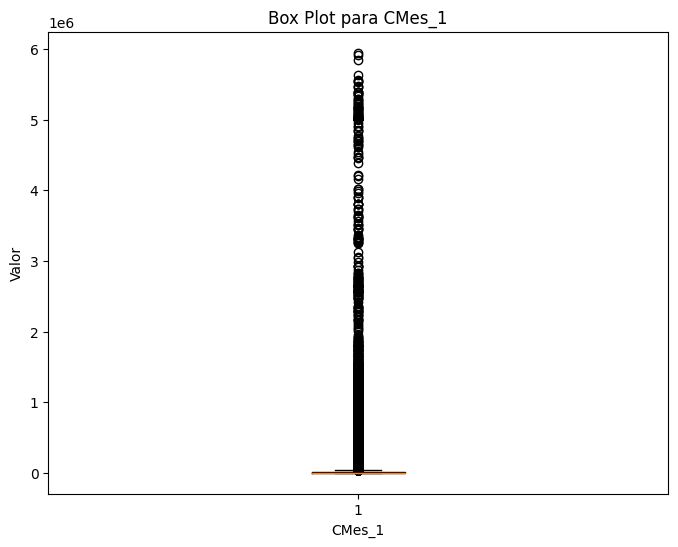

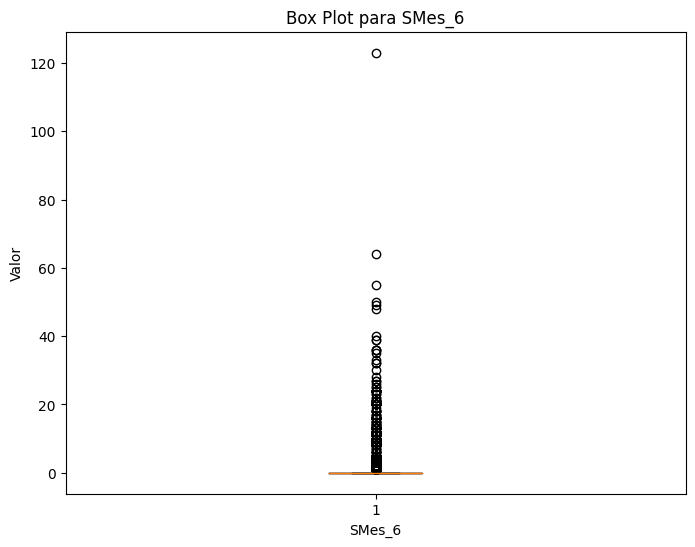

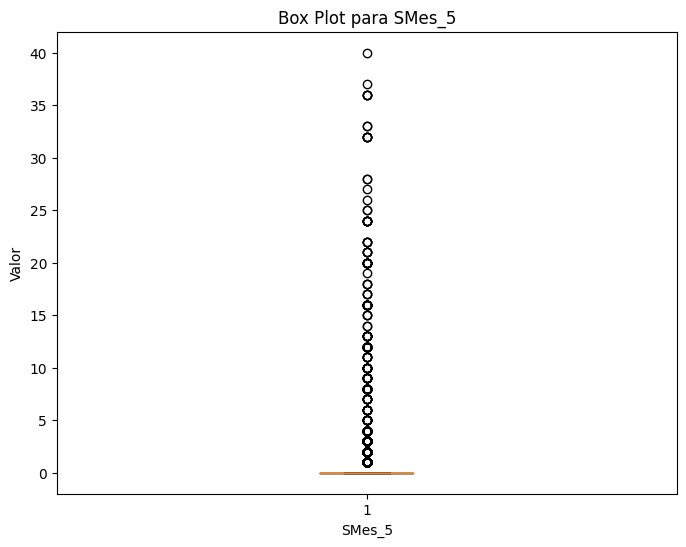

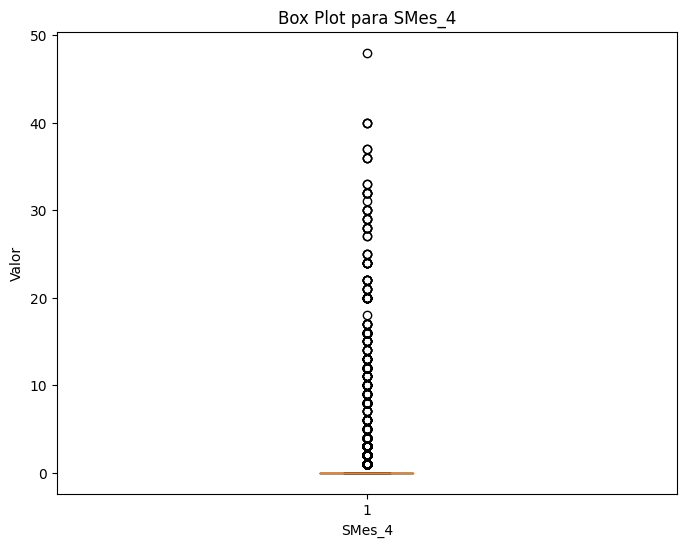

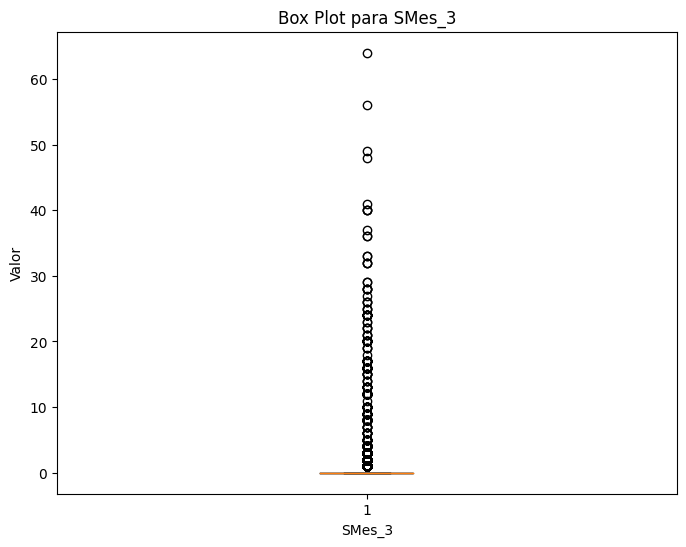

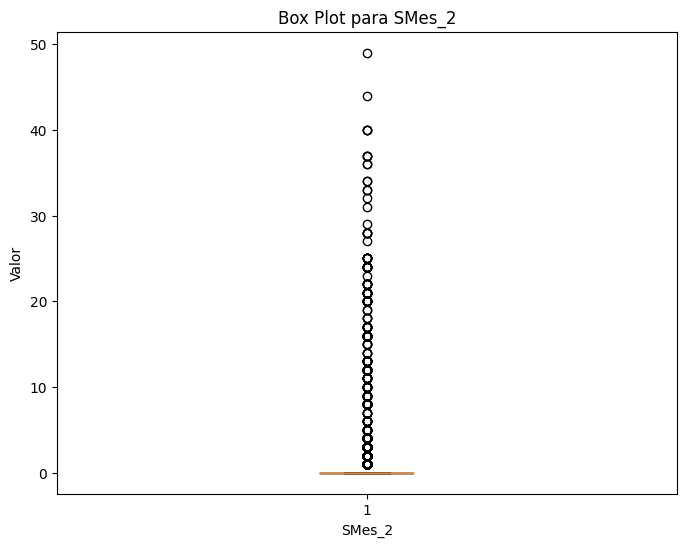

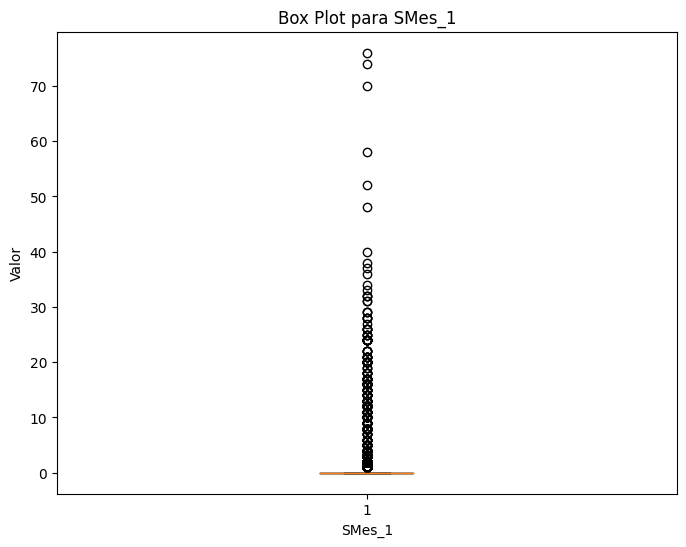

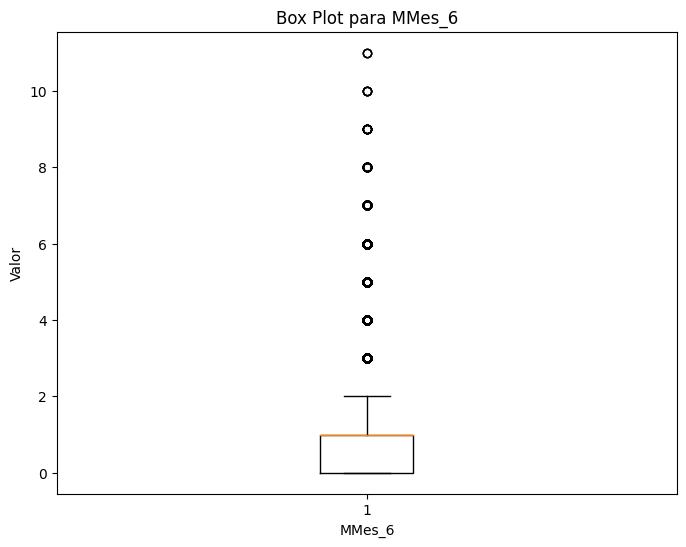

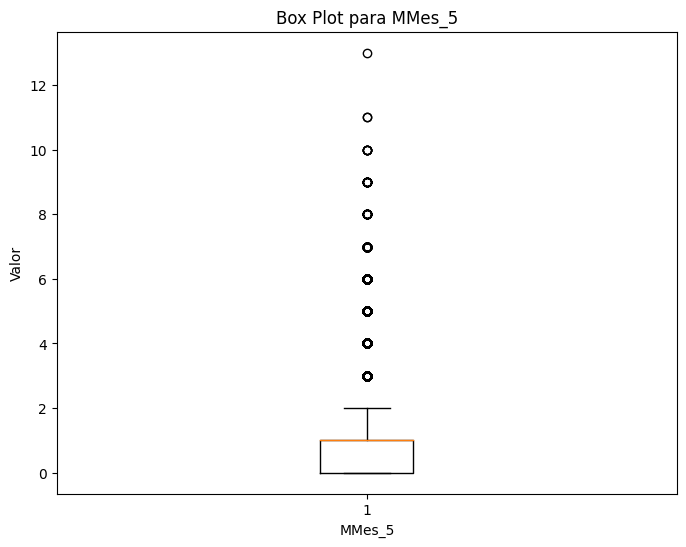

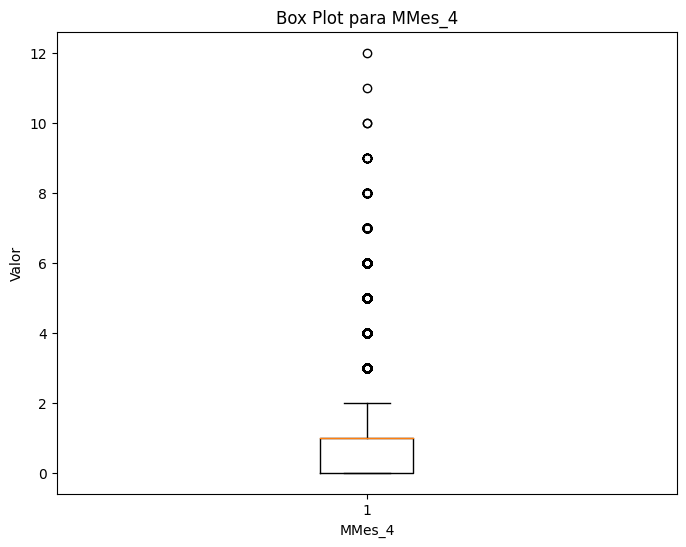

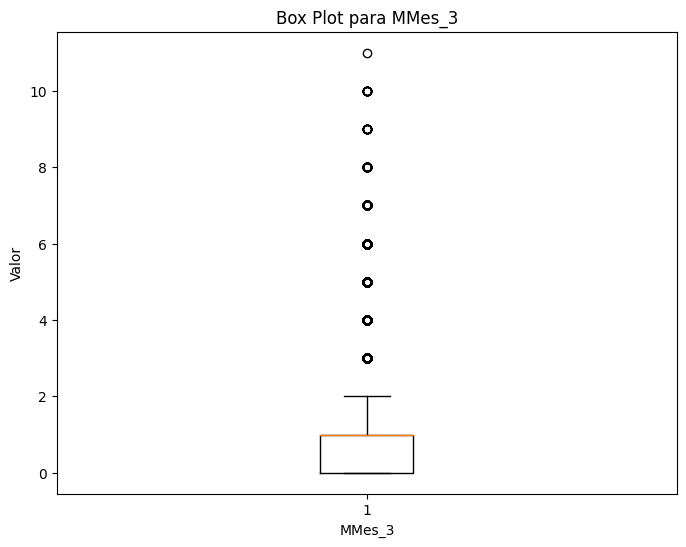

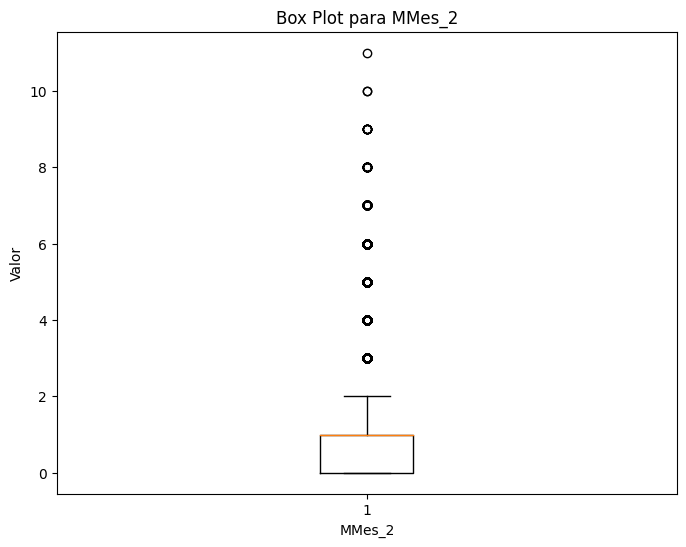

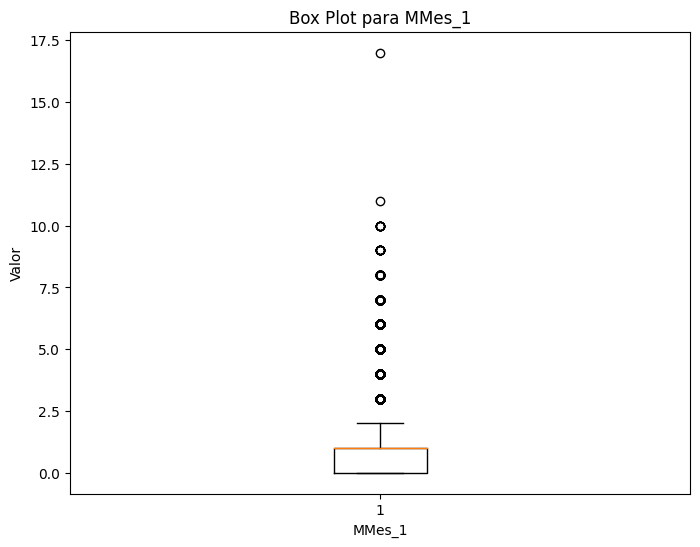

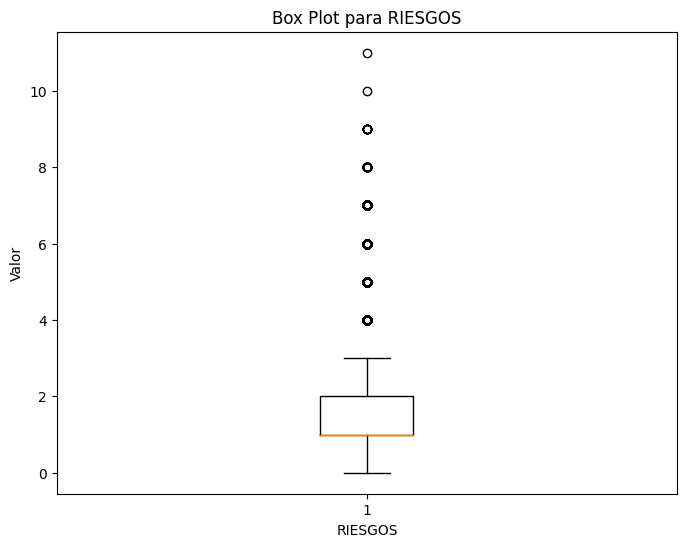

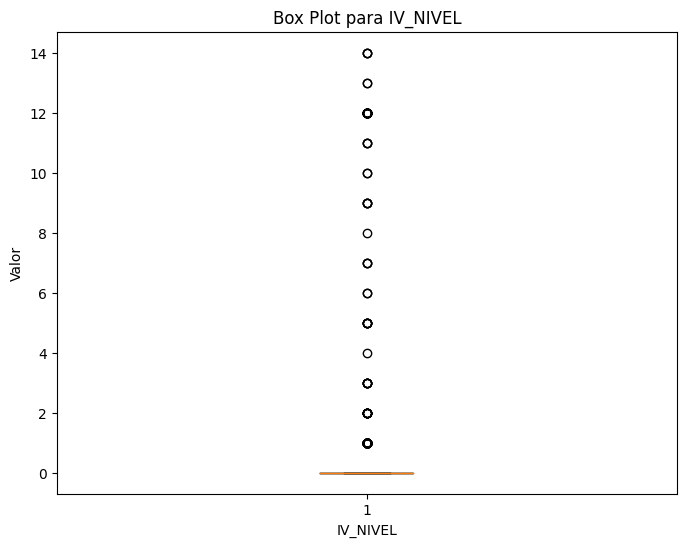

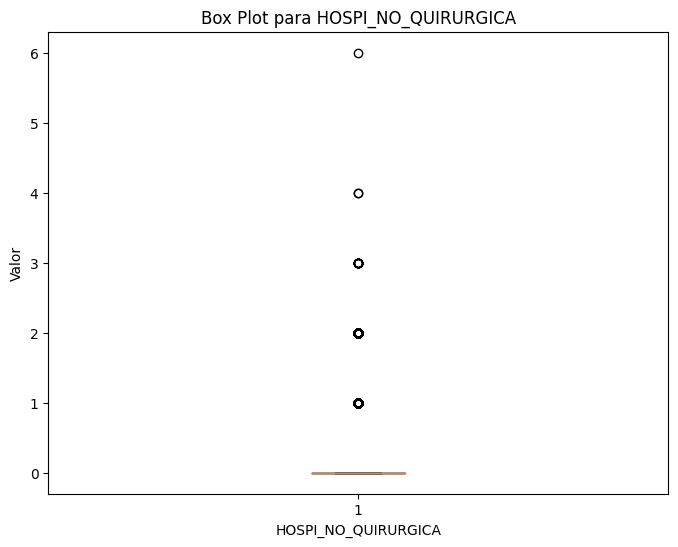

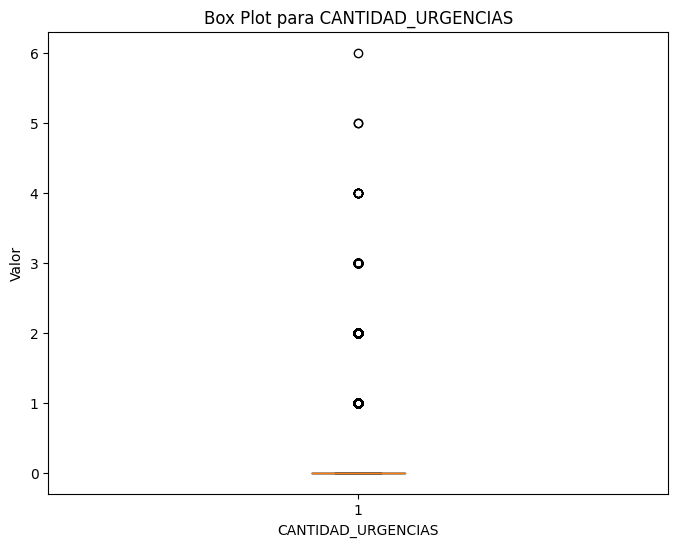

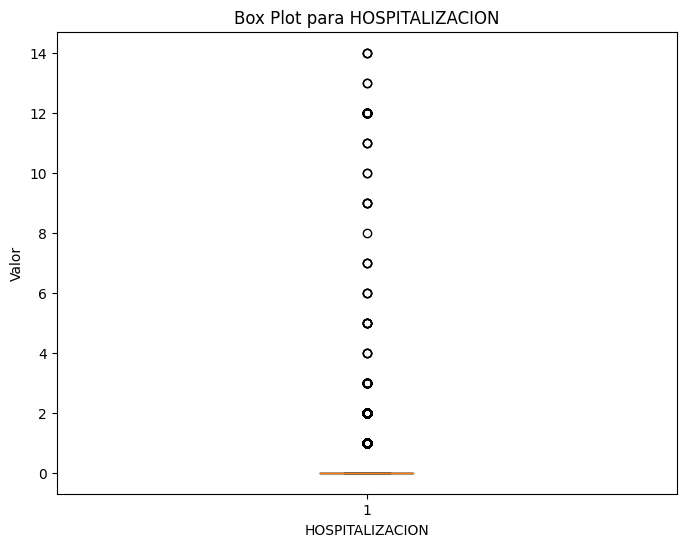

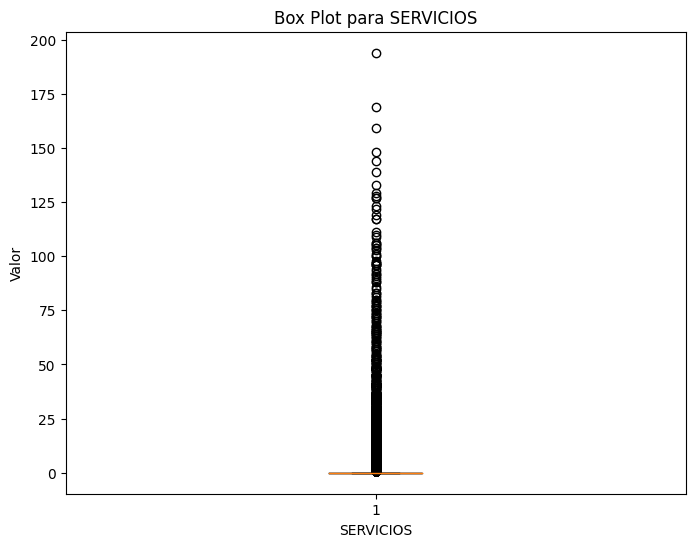

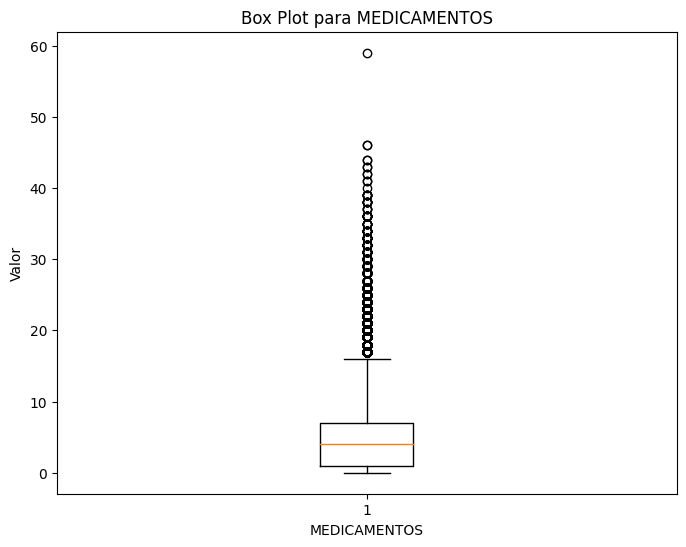

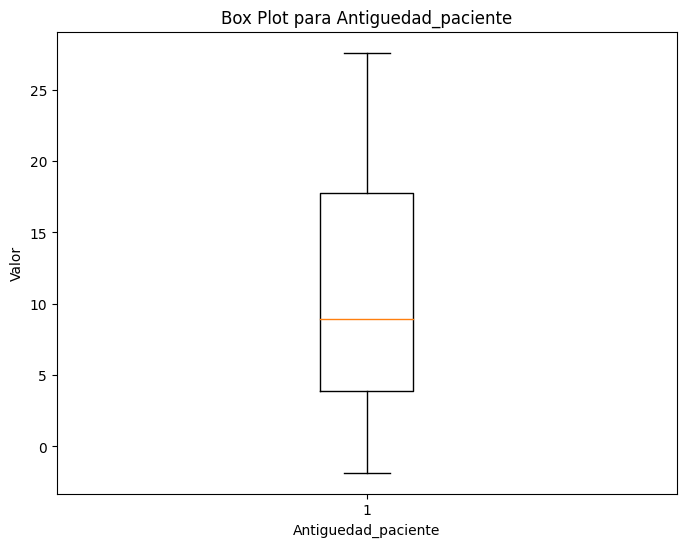

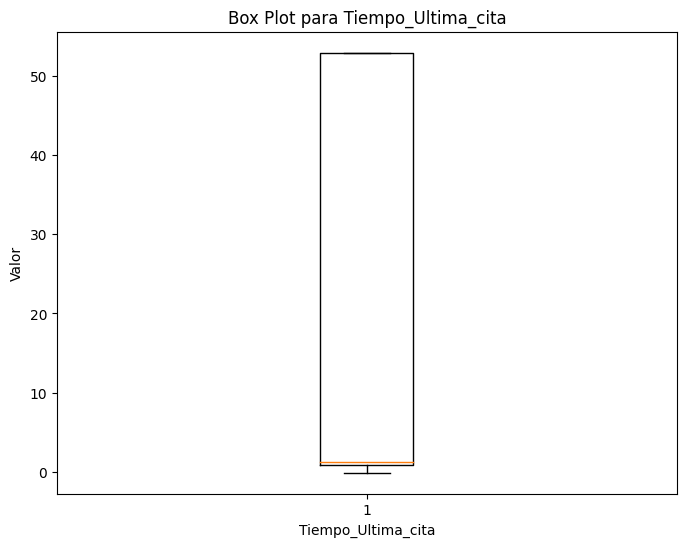

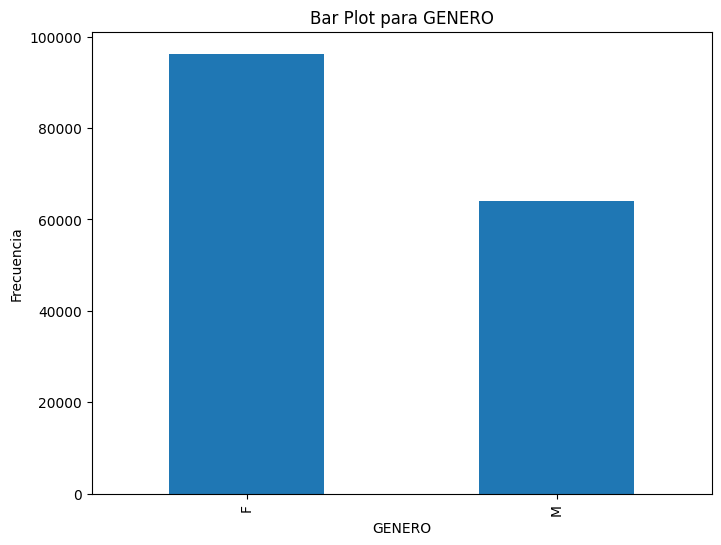

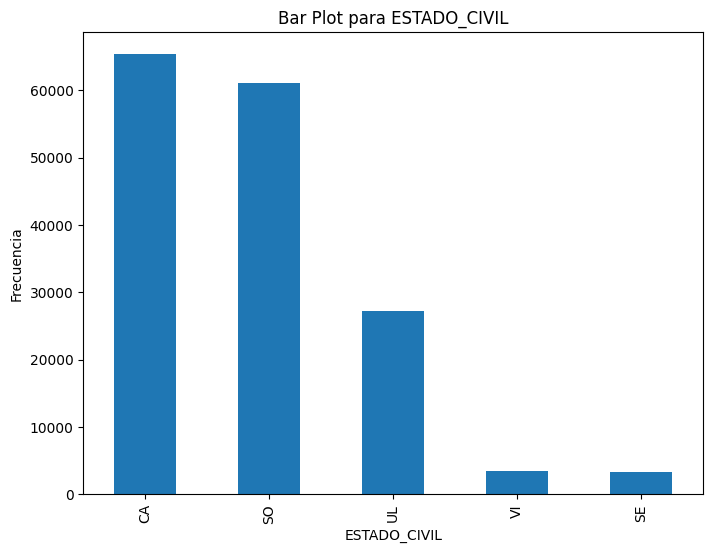

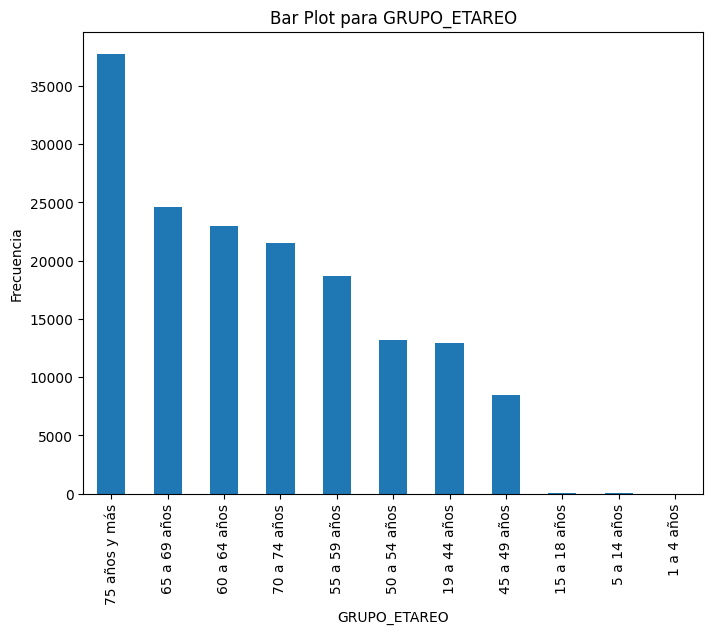

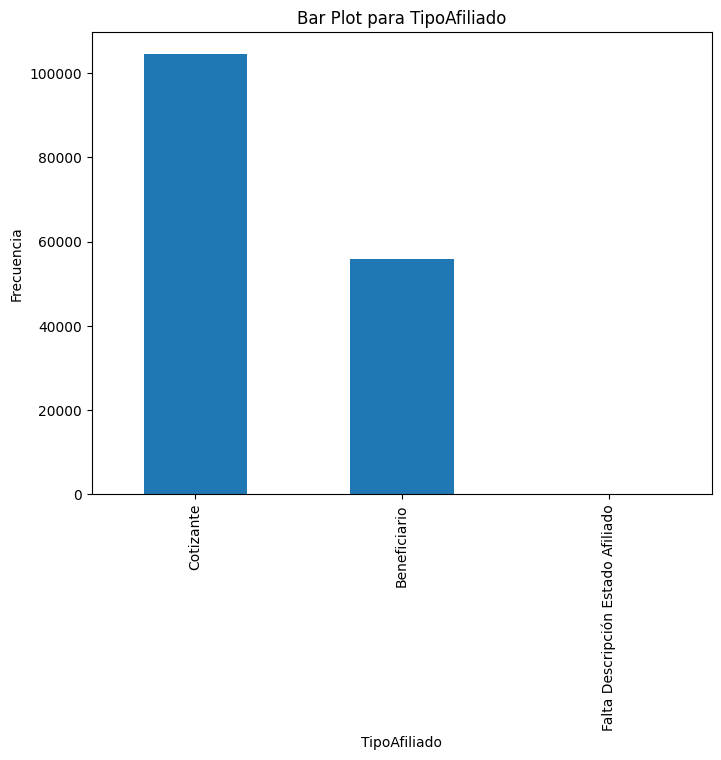

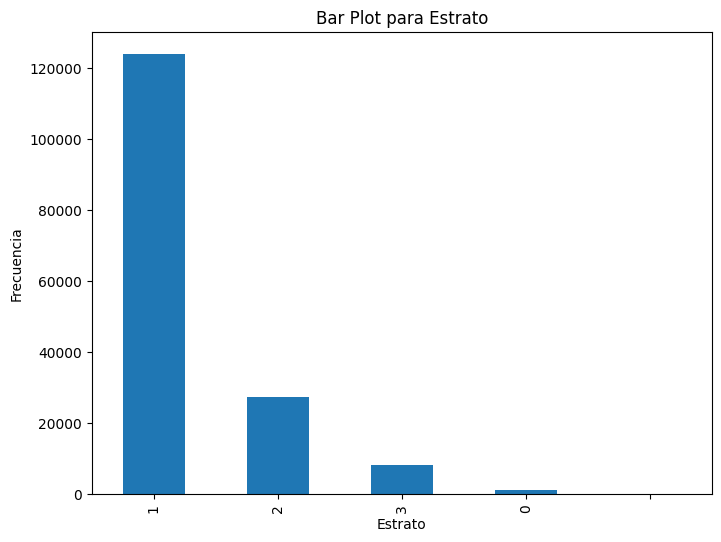

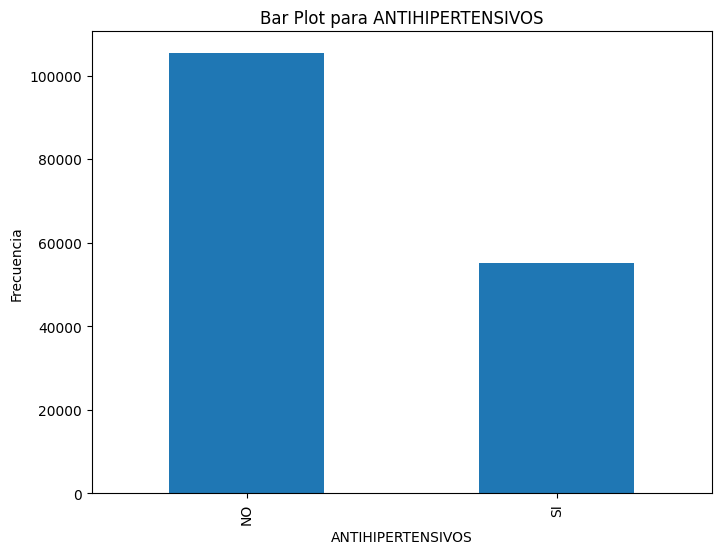

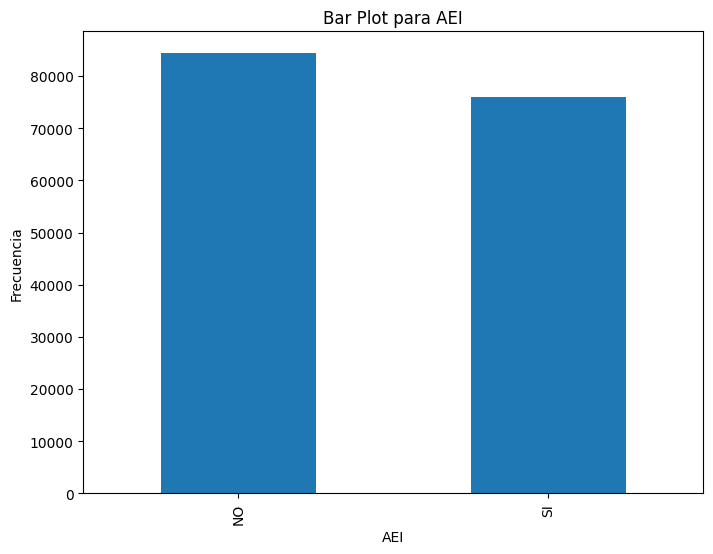

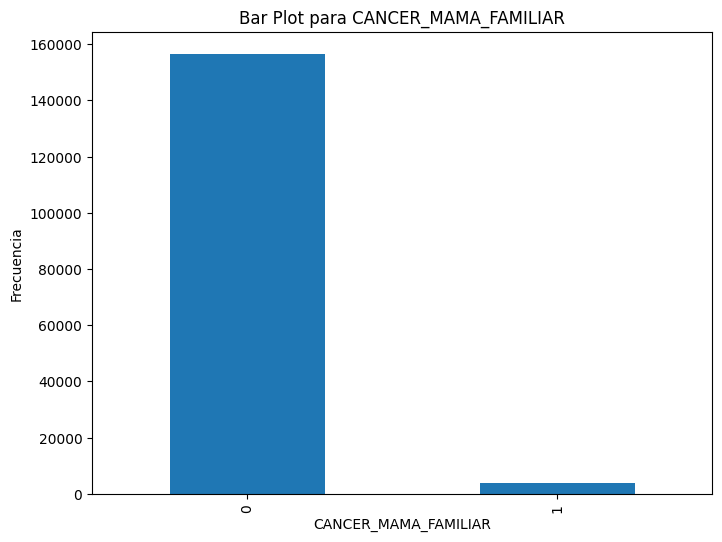

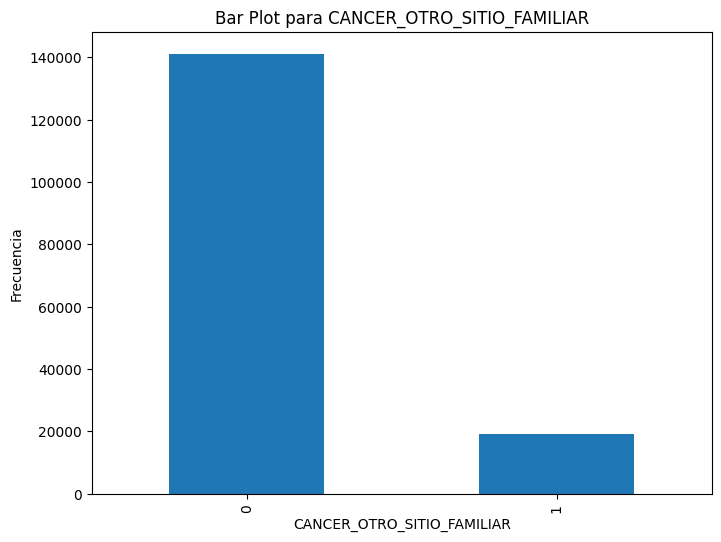

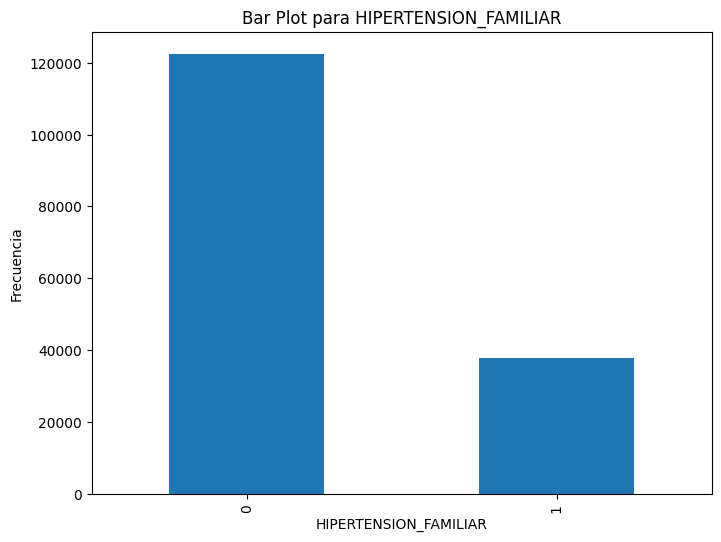

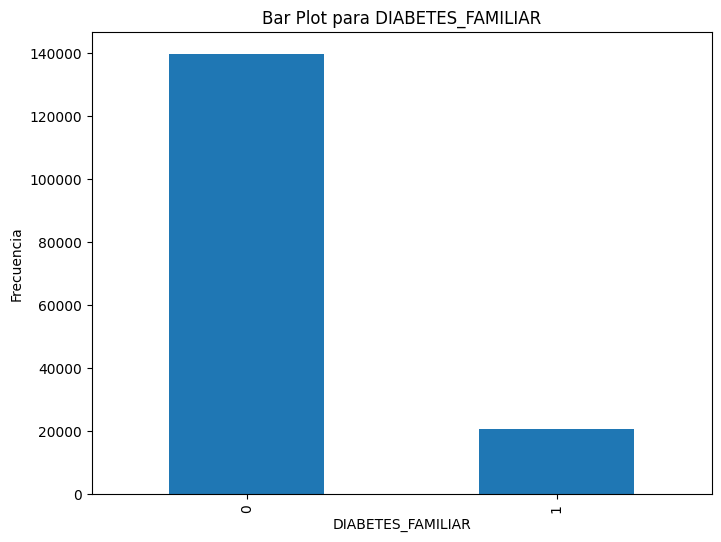

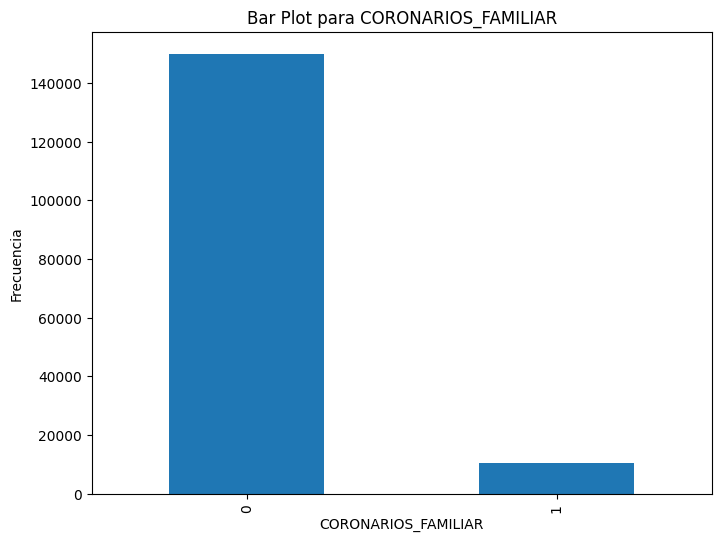

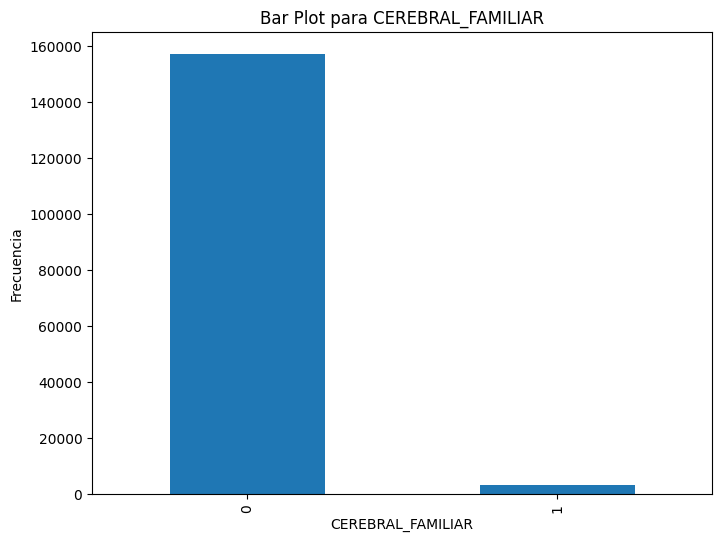

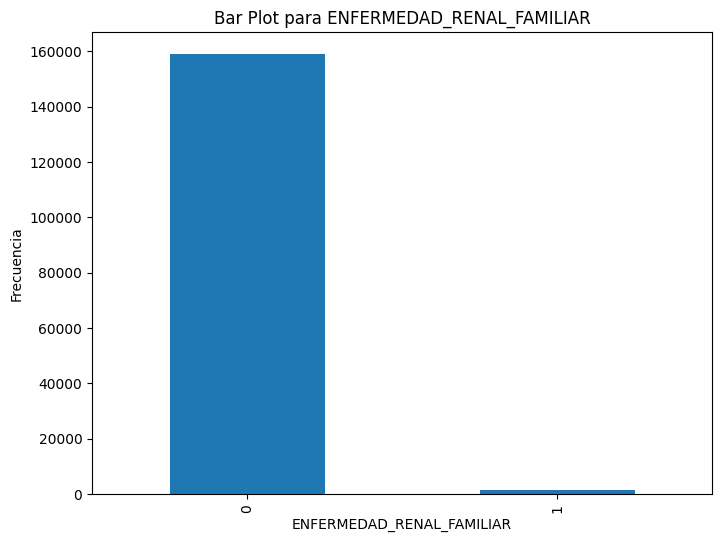

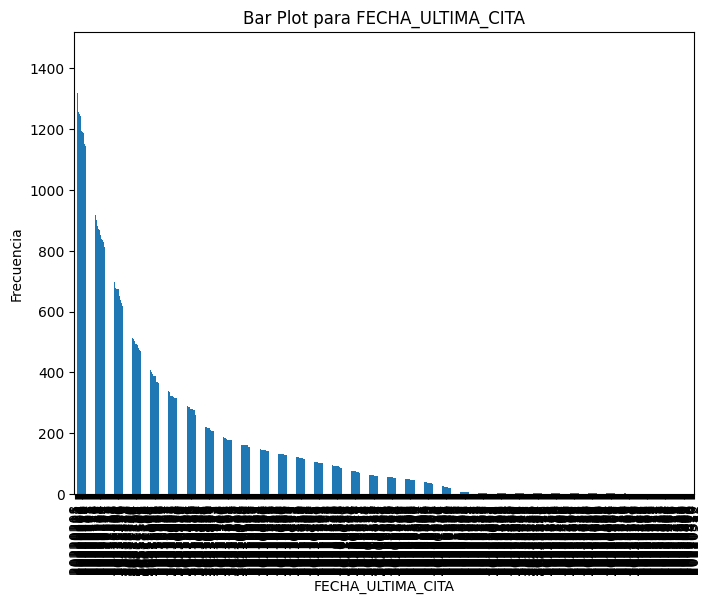

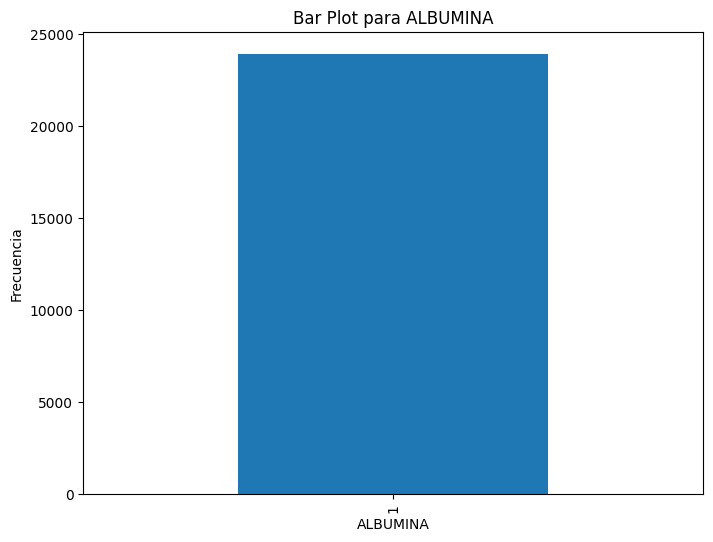

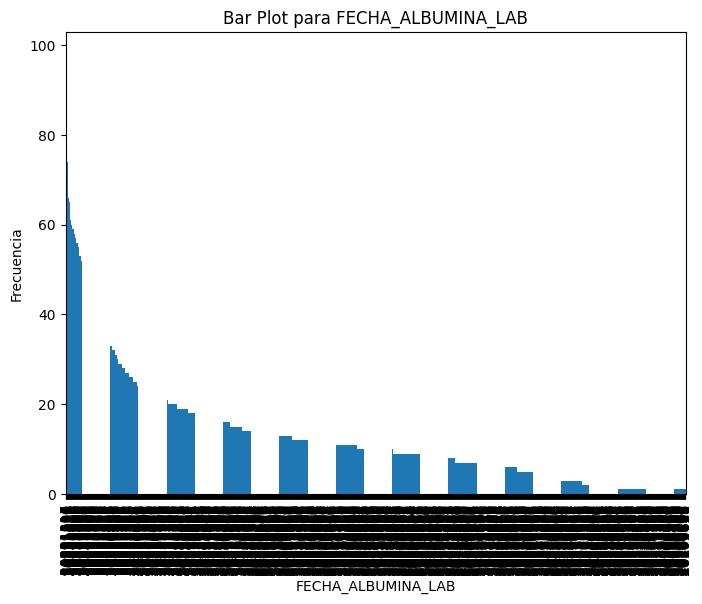

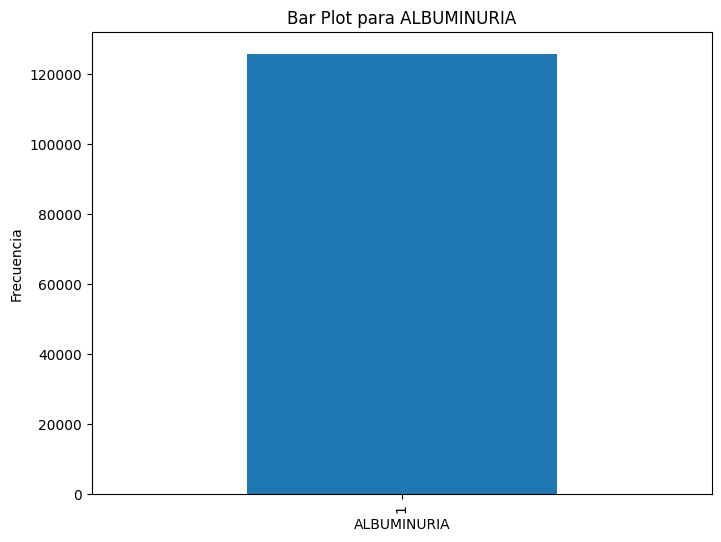

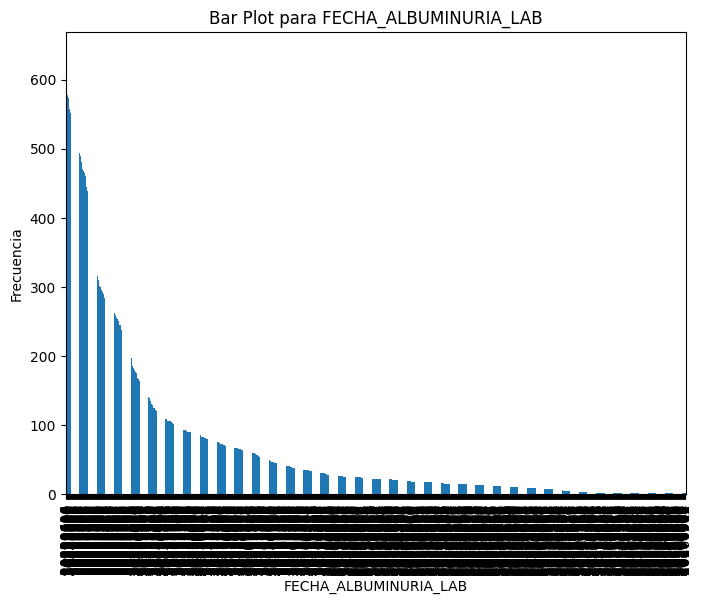

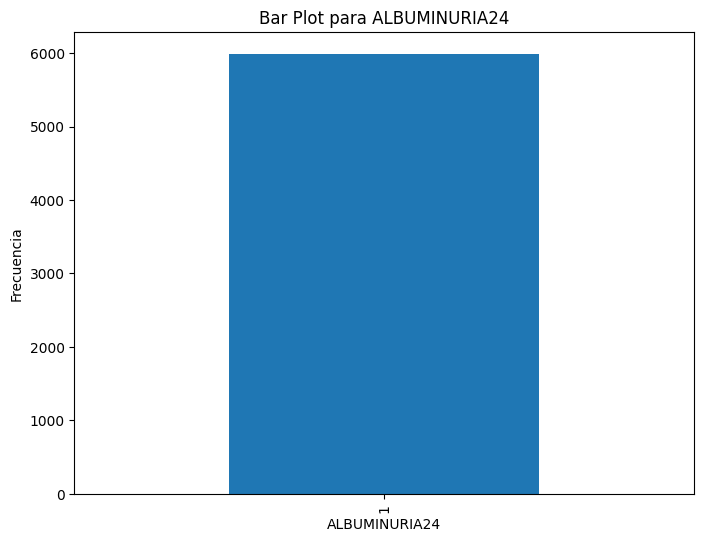

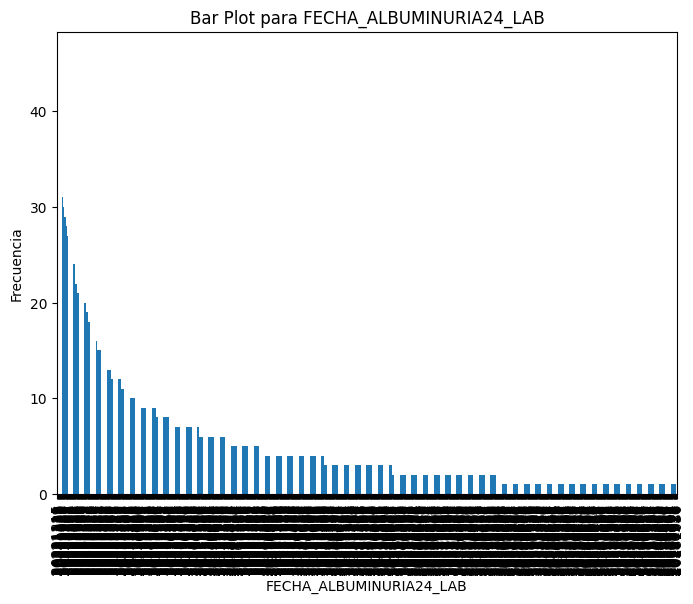

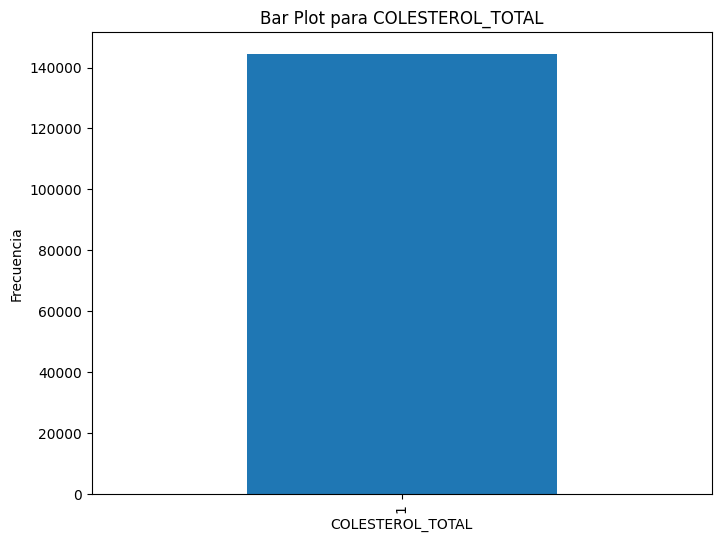

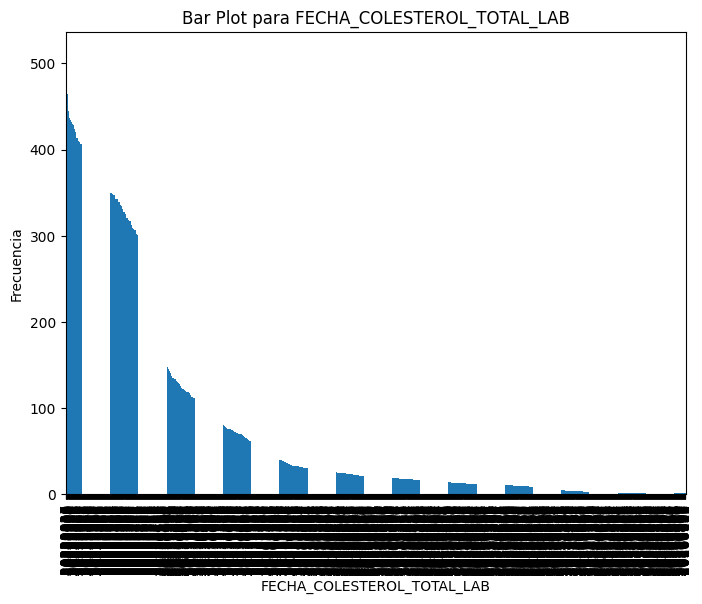

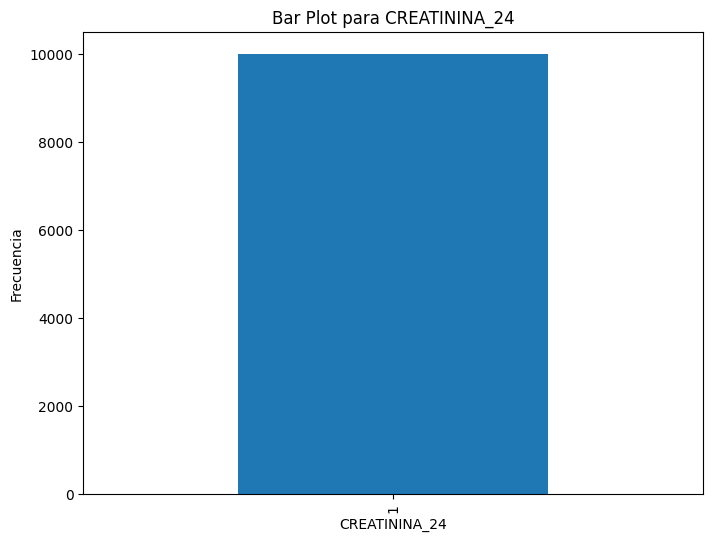

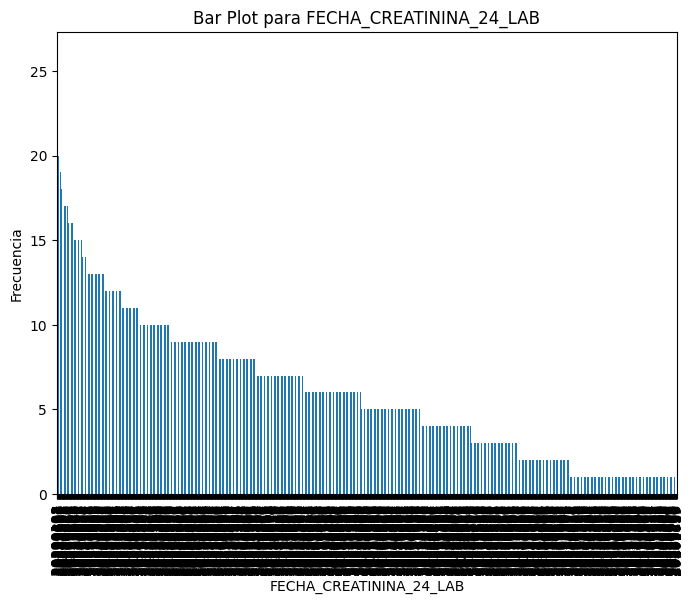

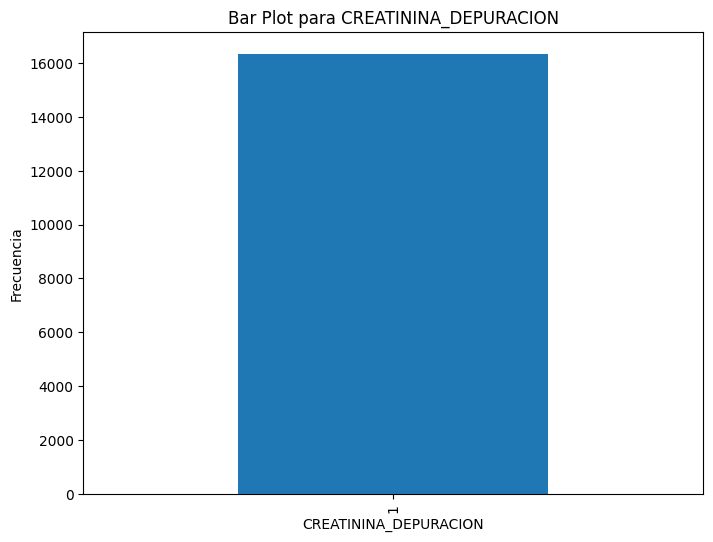

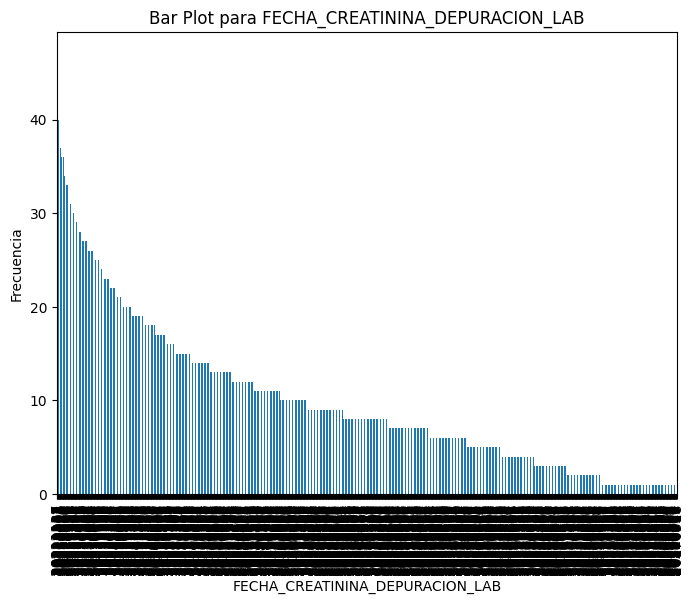

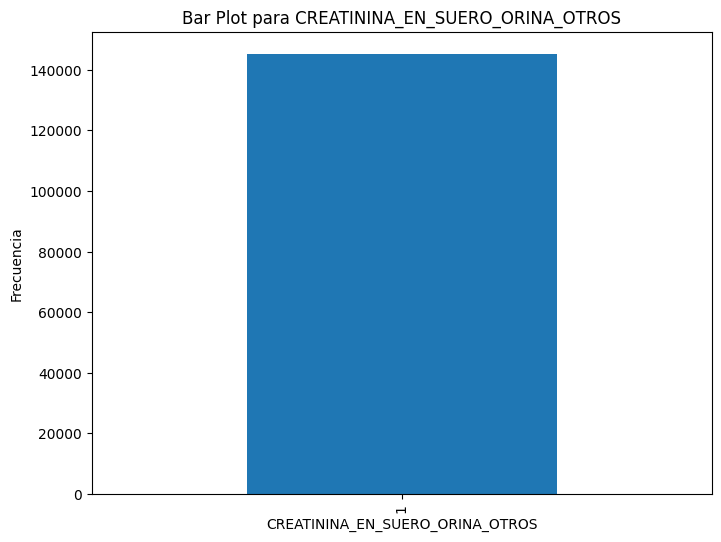

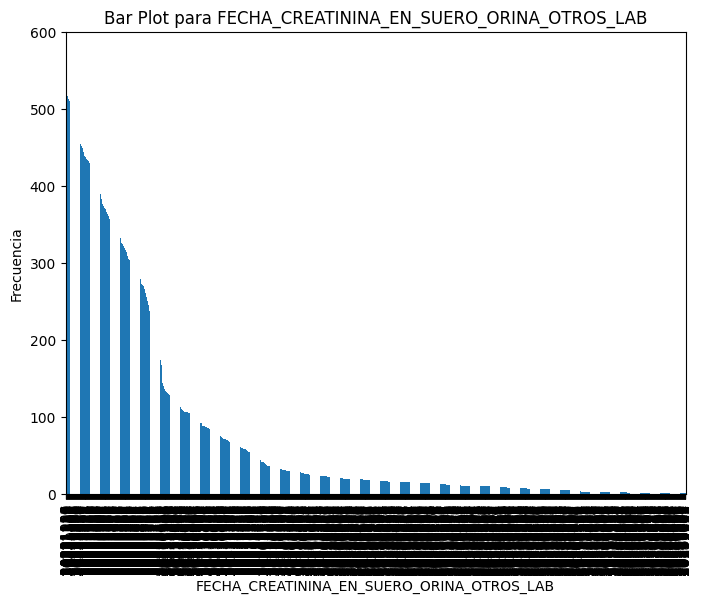

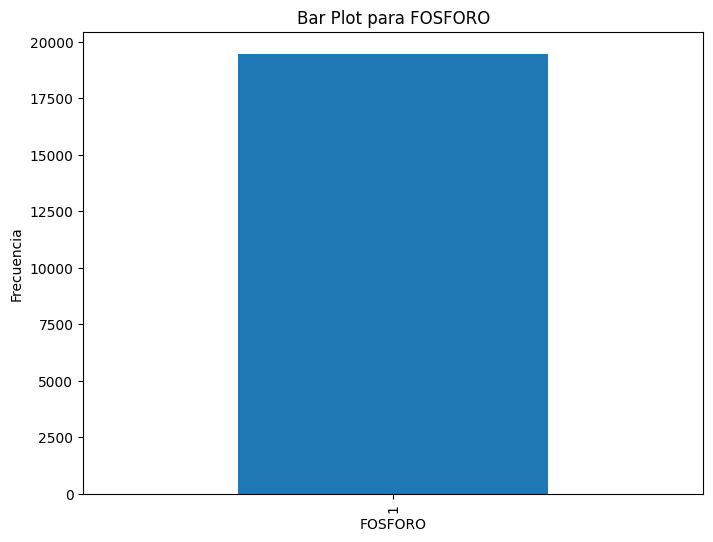

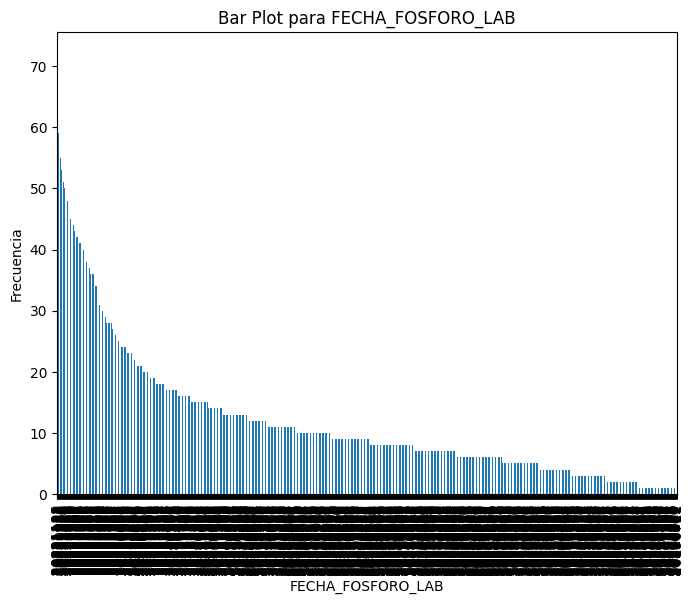

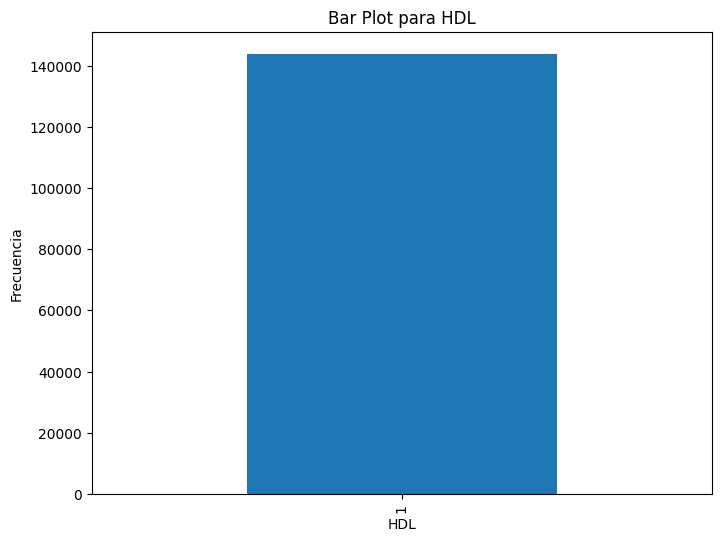

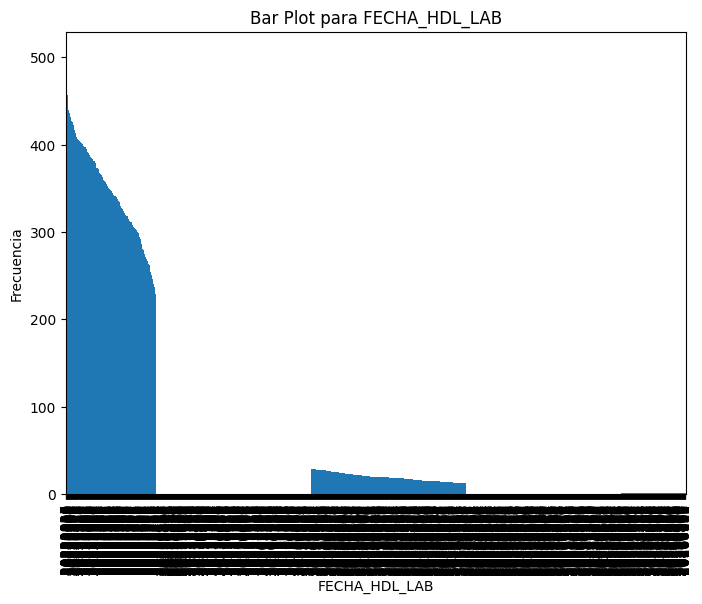

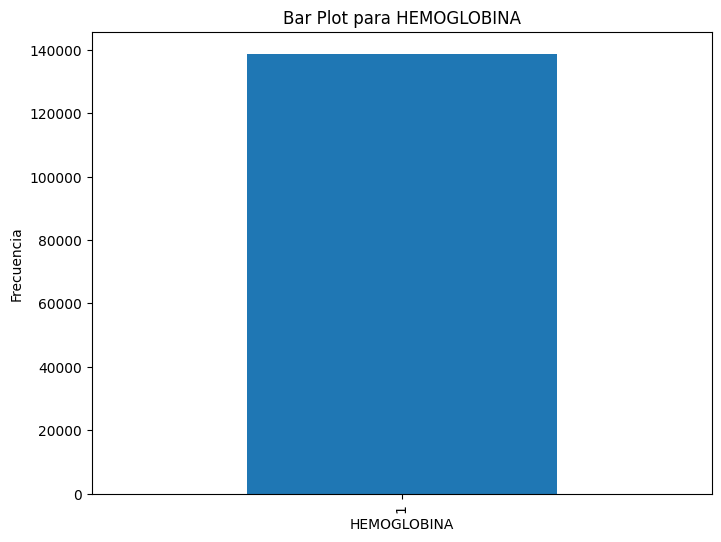

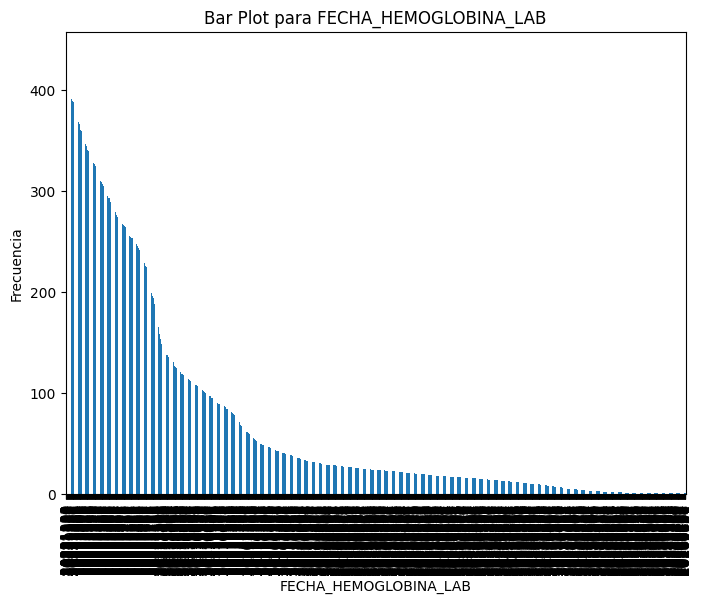

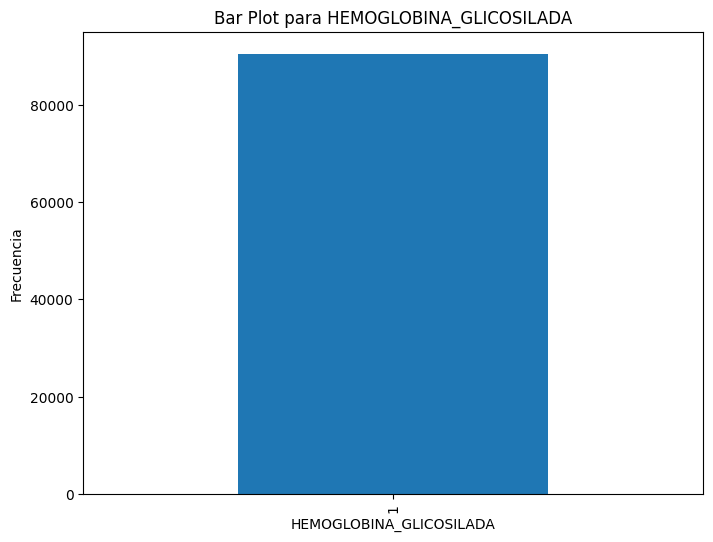

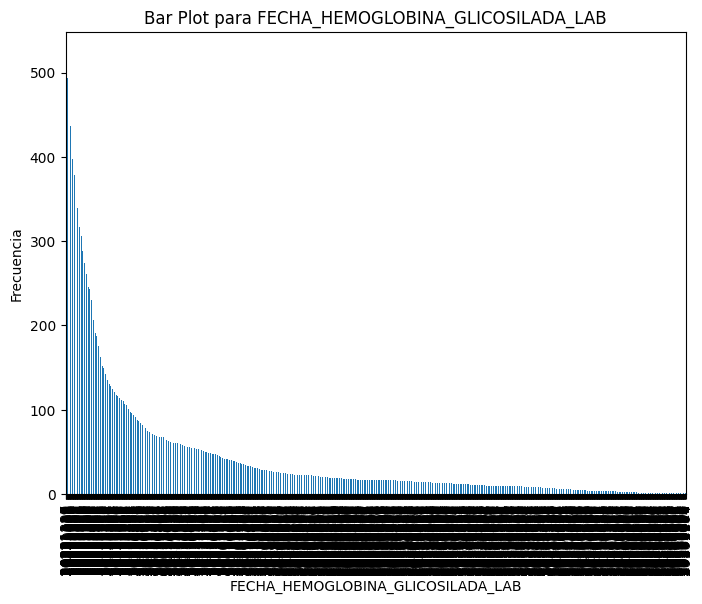

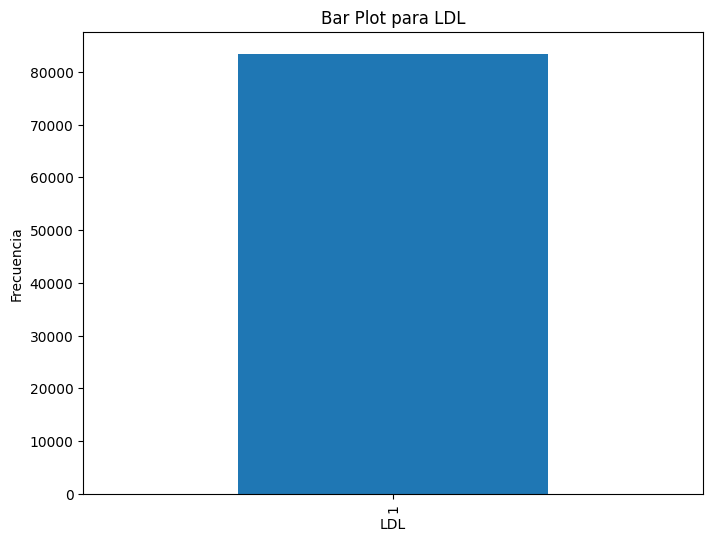

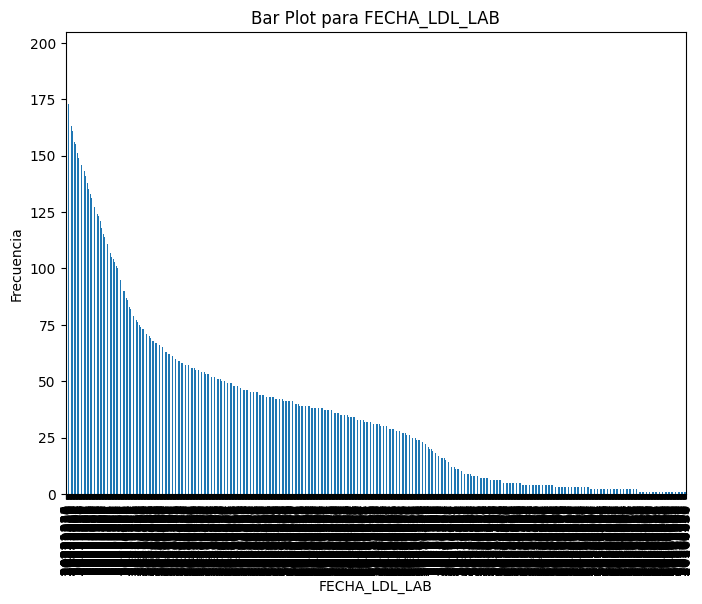

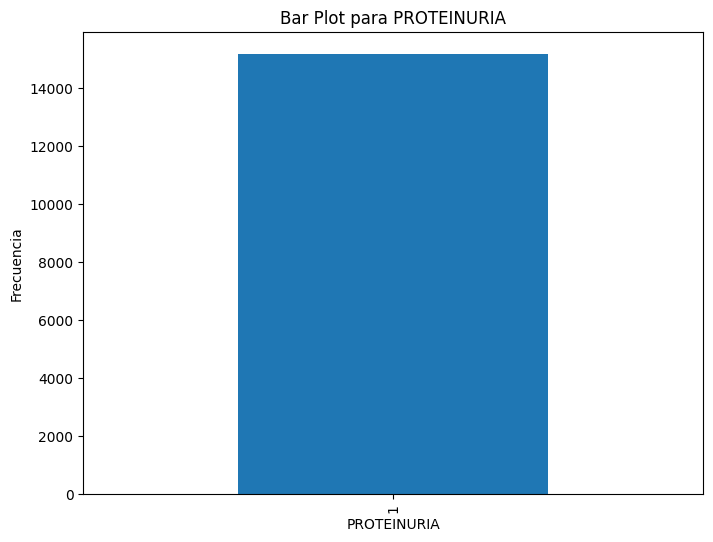

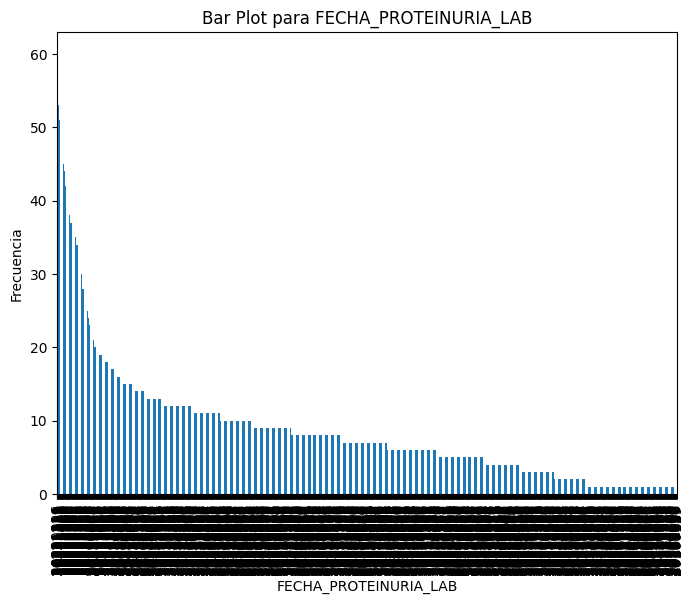

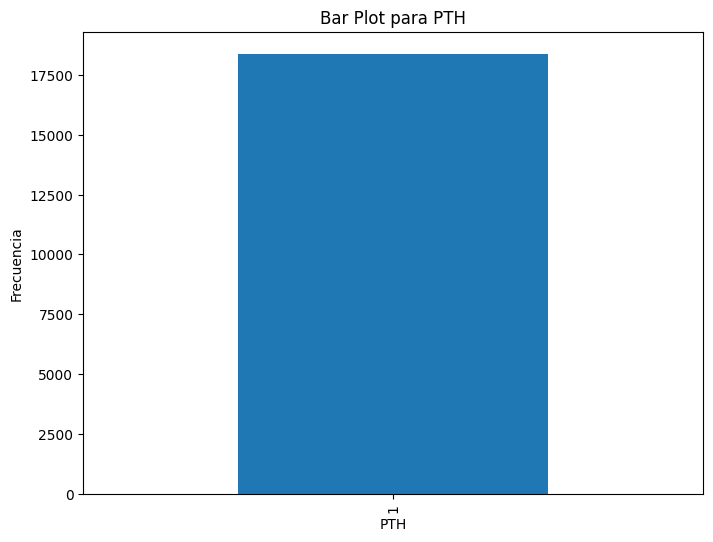

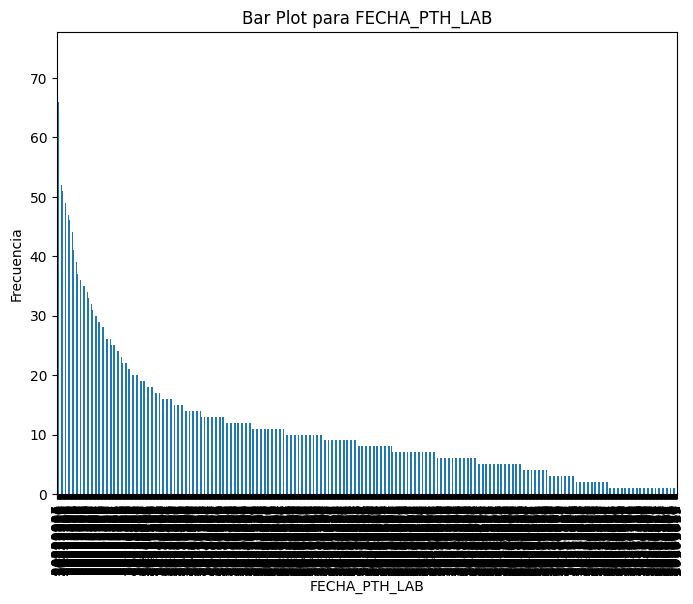

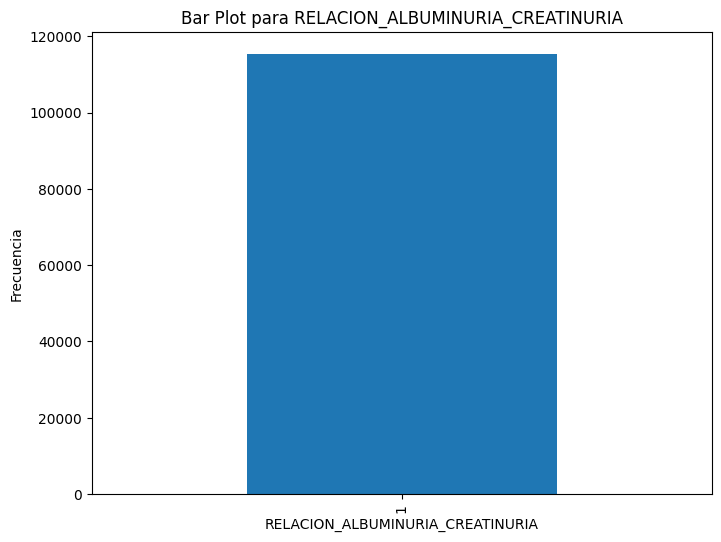

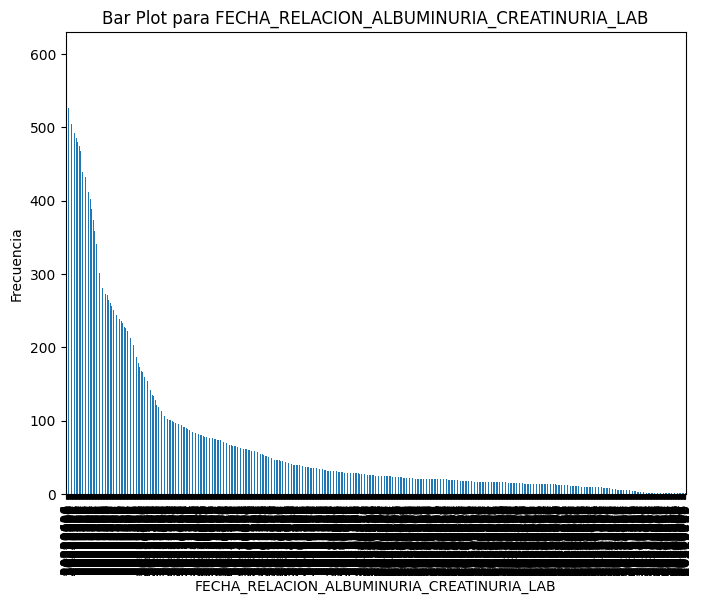

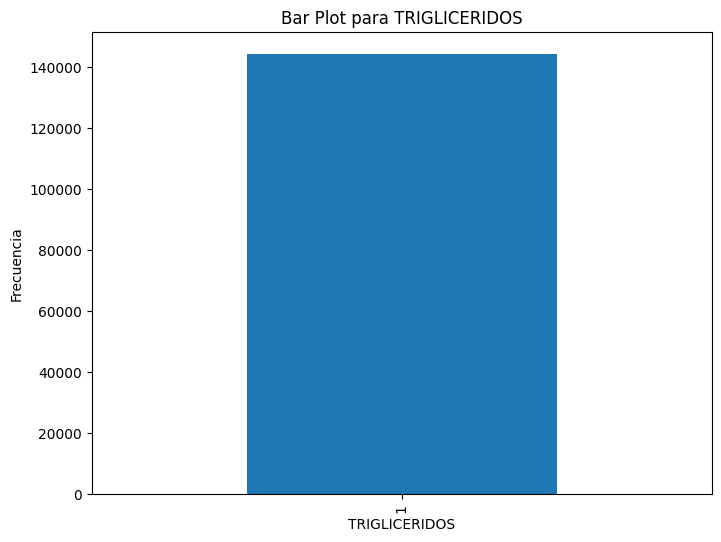

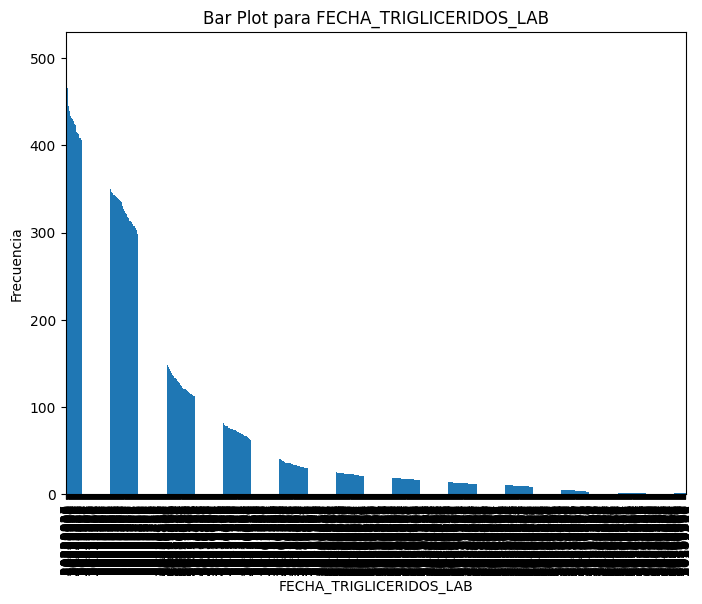

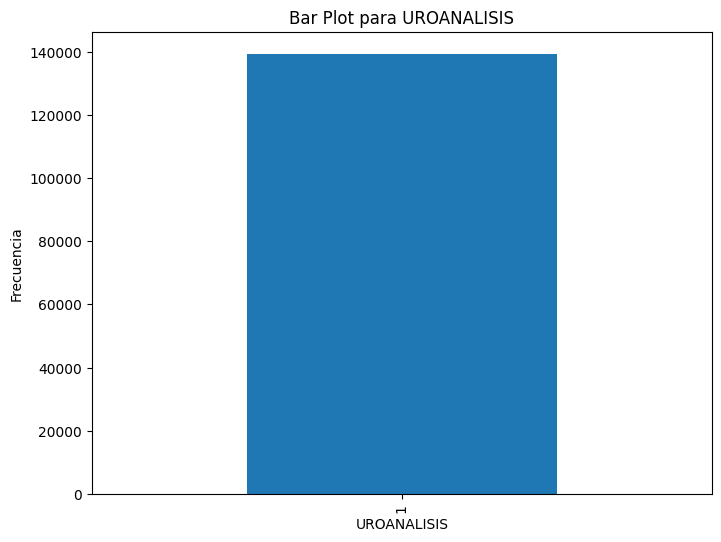

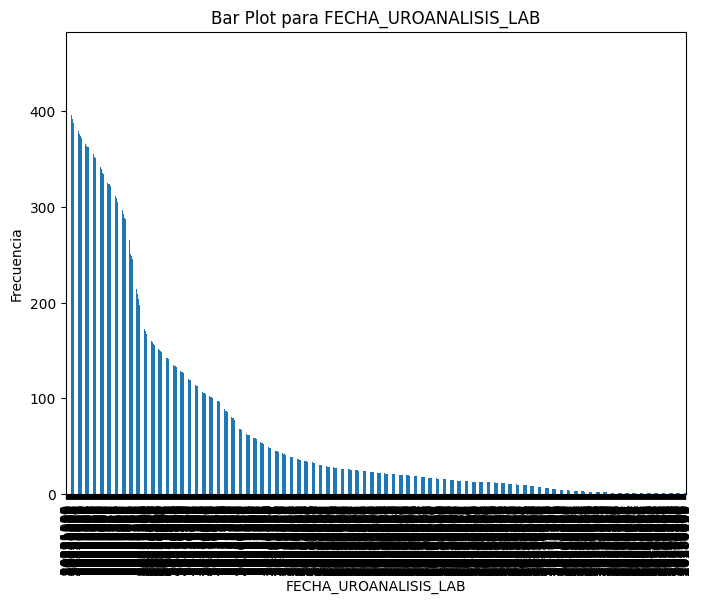

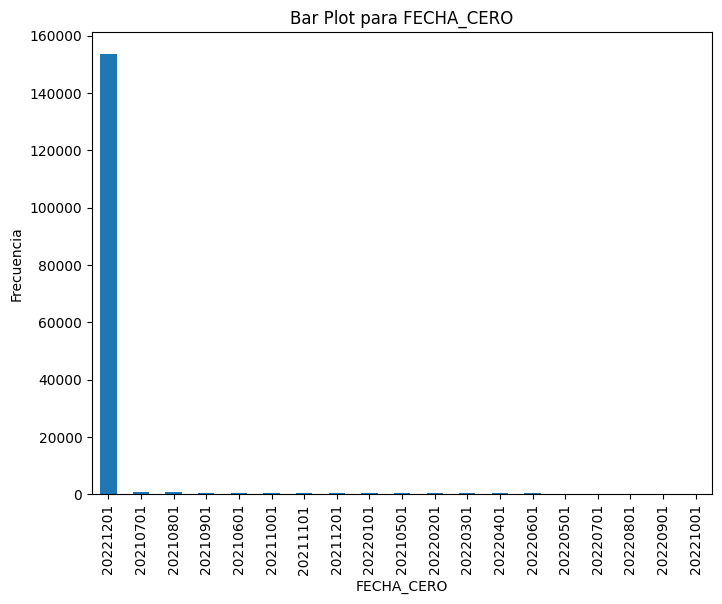

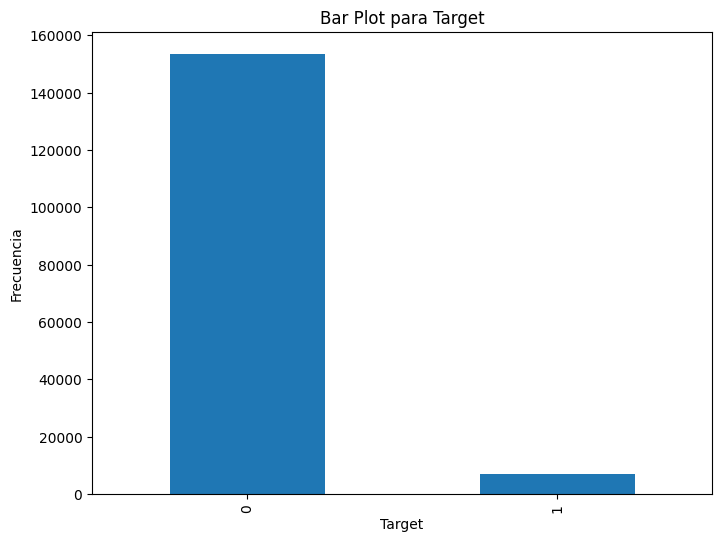

In [7]:
pipeline = PipelineDatos(df)

# Llamar a los métodos según sea necesario
pipeline.convertir_columnas()
pipeline.descriptivas()
pipeline.convertir_fecha_a_datetime()
nuevo_df = pipeline.procesar_columnas()

En los anteriores boxplots se observan varios datos "atipicos" en las variables numéricas, sin embargo, consideramos que la mayoría de datos que se consideran atipicos estadisticamente no lo son en este caso de estudio, como lo son por ejemplo los costos de los meses, cantidad de servicios y medicamentos, para estas variables se clasifican como atipicos algunos datos que consideramos normales, además no se alcanzaría a tener buena variabilidad, ya que el intervalo es muy pequeño. 

## Matriz de Correlación

In [8]:
class MyDataAnalyzer:
    def __init__(self, data):
        """
        Inicializa el analizador de datos con un DataFrame.

        Args:
            data (pd.DataFrame): El DataFrame que se desea analizar.
        """
        self.data = data

    def plot_correlation_matrix(self, save_to=None):
        """
        Genera y muestra una matriz de correlación de las columnas numéricas del DataFrame.

        Args:
            save_to (str, optional): La ruta donde guardar la visualización en lugar de mostrarla.
        """
        numeric_cols = self.data.select_dtypes(include=['float64', 'int64'])
        correlation_matrix = numeric_cols.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title('Matriz de Correlación')
        if save_to:
            plt.savefig(save_to)
        else:
            plt.show()

    def plot_association_matrix(self, save_to=None):
        """
        Genera y muestra una matriz de asociación de las columnas categóricas del DataFrame.

        Args:
            save_to (str, optional): La ruta donde guardar la visualización en lugar de mostrarla.
        """
        nominal_cols = self.data.select_dtypes(include=['object'])
       
        plt.figure(figsize=(10, 8))
        sns.heatmap(association_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title('Matriz de Asociación')
        if save_to:
            plt.savefig(save_to)
        else:
            plt.show()


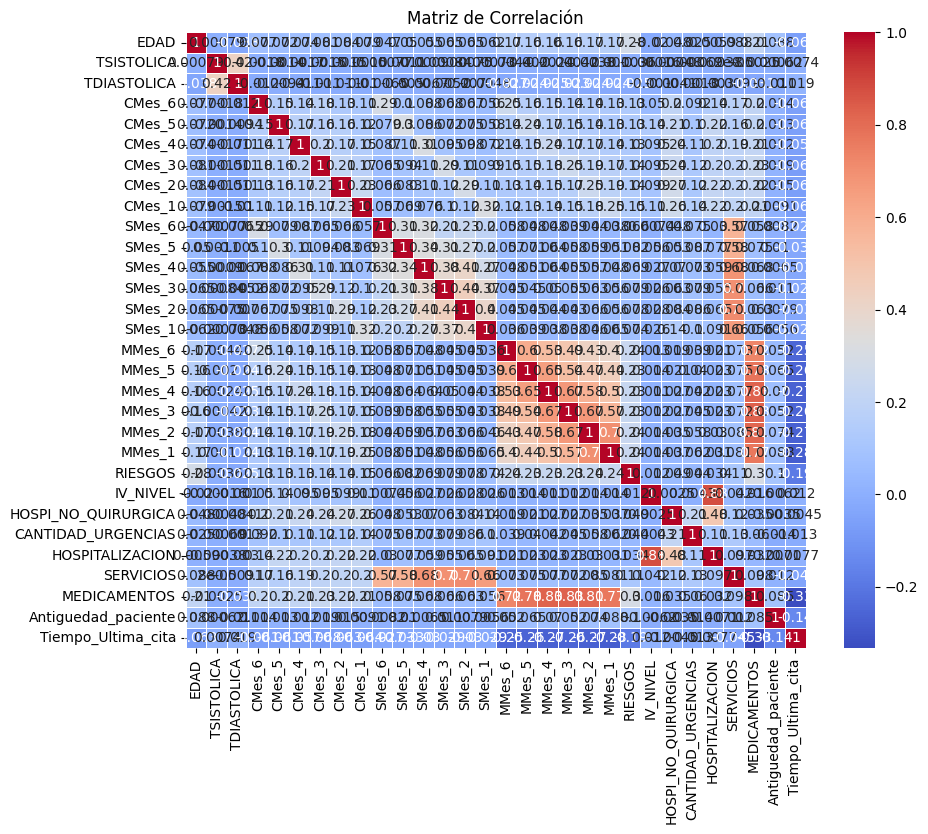

In [9]:
analyzer = MyDataAnalyzer(df)

# Llama a los métodos de la clase según sea necesario
analyzer.plot_correlation_matrix()  # Para la matriz de correlación
##analyzer.plot_association_matrix()

## Análisis e imputación de Outliers.

In [10]:
class OutlierImputer:
    def __init__(self, data, columns=None):
        """
        Inicializa el imputador de outliers con un DataFrame y las columnas de interés.

        Args:
            data (pd.DataFrame): El DataFrame que contiene los datos.
            columns (list, optional): Una lista de nombres de columnas en las que se desea aplicar el tratamiento.
                                      Si no se proporciona, se aplicará a todas las columnas numéricas.
        """
        self.data = data
        if columns is None:
            # Si no se especifican columnas, se aplicará a todas las columnas numéricas
            self.columns = data.select_dtypes(include=['float64', 'int64']).columns
        else:
            self.columns = columns

    def detect_outliers_iqr(self):
        outliers = {}
        for columna in self.columns:
            Q1 = self.data[columna].quantile(0.25)
            Q3 = self.data[columna].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            column_outliers = self.data[(self.data[columna] < lower_bound) | (self.data[columna] > upper_bound)][columna]
            outliers[columna] = column_outliers

        return outliers

    def impute_outliers_iqr_in_df(self):
        for columna in self.columns:
            Q1 = self.data[columna].quantile(0.25)
            Q3 = self.data[columna].quantile(0.85)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            self.data[columna] = self.data[columna].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))


In [11]:
outliersdata = ['EDAD', 'TSISTOLICA', 'TDIASTOLICA']
imputer = OutlierImputer(df, columns=outliersdata)

outliers = imputer.detect_outliers_iqr()

imputer.impute_outliers_iqr_in_df()


Como se mencionó anteriormente, para este estudio sólo se consideraron valores atipicos en las variables (EDAD, TSISTOLICA, TDIASTOLICA), por lo tanto, se realizó imputación de outliers con minimos y máximos intercuartiles únicamente en ellas. Para el resto de variables numéricas no se hizo ningún tratamiento porque no fueron considerados como valores "atipicos".

In [12]:
class ProcesadorFechas:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.columnas_fechas = [
            'FECHA_ULTIMA_CITA',
            'FECHA_ALBUMINA_LAB',
            'FECHA_ALBUMINURIA24_LAB',
            'FECHA_CREATININA_24_LAB',
            'FECHA_CREATININA_DEPURACION_LAB',
            'FECHA_FOSFORO_LAB',
            'FECHA_HEMOGLOBINA_GLICOSILADA_LAB',
            'FECHA_PROTEINURIA_LAB',
            'FECHA_PTH_LAB',
            'FECHA_ALBUMINURIA_LAB',
            'FECHA_LDL_LAB',
            'FECHA_COLESTEROL_TOTAL_LAB',
            'FECHA_CREATININA_EN_SUERO_ORINA_OTROS_LAB',
            'FECHA_HDL_LAB',
            'FECHA_HEMOGLOBINA_LAB',
            'FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB',
            'FECHA_TRIGLICERIDOS_LAB',
            'FECHA_UROANALISIS_LAB'
        ]

    def convertir_fechas(self):
        # Convierte la columna 'FECHA_CERO' al formato datetime
        self.dataframe['FECHA_CERO'] = pd.to_datetime(self.dataframe['FECHA_CERO'], format='%Y%m%d', errors='coerce')

        # Convierte las columnas de fechas al formato datetime
        for columna in self.columnas_fechas:
            self.dataframe[columna] = pd.to_datetime(self.dataframe[columna], format='%Y%m%d', errors='coerce')

    def calcular_distancia_en_dias(self):
        # Calcula la distancia en días y reemplaza las fechas por los valores de días
        for columna in self.columnas_fechas:
            self.dataframe[columna] = (self.dataframe['FECHA_CERO'] - self.dataframe[columna]).dt.days
            


Se calcularon los días transcurridos entre cada fecha de examen y la fecha cero para obtener mayor información sobre cada individuo de este estudio, esto conduce a resultados más confiables en los modelos.

In [13]:
procesador = ProcesadorFechas(df)
procesador.convertir_fechas()
procesador.calcular_distancia_en_dias()

In [14]:
columnas_fechas = [
            'FECHA_ULTIMA_CITA',
            'FECHA_ALBUMINA_LAB',
            'FECHA_ALBUMINURIA24_LAB',
            'FECHA_CREATININA_24_LAB',
            'FECHA_CREATININA_DEPURACION_LAB',
            'FECHA_FOSFORO_LAB',
            'FECHA_HEMOGLOBINA_GLICOSILADA_LAB',
            'FECHA_PROTEINURIA_LAB',
            'FECHA_PTH_LAB',
            'FECHA_ALBUMINURIA_LAB',
            'FECHA_LDL_LAB',
            'FECHA_COLESTEROL_TOTAL_LAB',
            'FECHA_CREATININA_EN_SUERO_ORINA_OTROS_LAB',
            'FECHA_HDL_LAB',
            'FECHA_HEMOGLOBINA_LAB',
            'FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB',
            'FECHA_TRIGLICERIDOS_LAB',
            'FECHA_UROANALISIS_LAB'
        ]

Las fechas con valores nulos fueron imputadas con el valor (0)

In [15]:
columnas_de_fecha = df.select_dtypes(include=['datetime64']).columns
df[columnas_fechas] = df[columnas_fechas].fillna(0)

In [16]:
columnas_de_fecha

Index(['FECHA_CERO'], dtype='object')

In [17]:
df1=df

In [18]:
def procesar_valores_negativos(dataframe, columnas_fechas):
    for columna in columnas_fechas:
        # Reemplazar valores negativos por 0
        dataframe[columna] = dataframe[columna].apply(lambda x: x if x >= 0 else 0)
    return dataframe  # Retorna el DataFrame modificado

columnas_fechas = [
    'FECHA_ULTIMA_CITA',
    'FECHA_ALBUMINA_LAB',
    'FECHA_ALBUMINURIA24_LAB',
    'FECHA_CREATININA_24_LAB',
    'FECHA_CREATININA_DEPURACION_LAB',
    'FECHA_FOSFORO_LAB',
    'FECHA_HEMOGLOBINA_GLICOSILADA_LAB',
    'FECHA_PROTEINURIA_LAB',
    'FECHA_PTH_LAB',
    'FECHA_ALBUMINURIA_LAB',
    'FECHA_LDL_LAB',
    'FECHA_COLESTEROL_TOTAL_LAB',
    'FECHA_CREATININA_EN_SUERO_ORINA_OTROS_LAB',
    'FECHA_HDL_LAB',
    'FECHA_HEMOGLOBINA_LAB',
    'FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB',
    'FECHA_TRIGLICERIDOS_LAB',
    'FECHA_UROANALISIS_LAB'
]

# Llamar a la función para procesar los valores negativos
df = procesar_valores_negativos(df, columnas_fechas)


Para los días negativos, es decir las fechas que superaron en tiempo a la fecha cero, se dicidio imputarlos con el valor (0). 

## Análisis de missing values. 

In [19]:
def imputar_valores_nulos(dataframe):
    for columna in dataframe.columns:
        if dataframe[columna].dtype == 'float64':
            # Imputar valores nulos con la media de la columna
            media = dataframe[columna].mean()
            dataframe[columna].fillna(media, inplace=True)
        elif dataframe[columna].dtype == 'object':
            # Imputar valores nulos con 0 en columnas de tipo objeto
            dataframe[columna].fillna('0', inplace=True)
    
    return dataframe

df = imputar_valores_nulos(df1)


Los valores nulos para variables categóricas fueron imputados con el valor de (0) y las variables numéricas en sus nulos fueron imputadas por la media

### Dumificación de variables categóricas:

In [20]:
columnas_categoricas = [col for col in df.columns if df[col].dtype == 'object' and col != 'Target']

df_encoded = pd.get_dummies(df, columns=columnas_categoricas)

## PCA

In [22]:
class PrincipalComponentAnalysis:
    def __init__(self, data):
        self.data = data
        self.normalized_data = self.normalize_data()
        self.pca = PCA()
        self.pca.fit(self.normalized_data)
        self.component_columns = [f'principal component {i}' for i in range(1, len(self.data.columns) + 1)]
        self.principal_df = self.calculate_principal_components()
        self.component_loadings = pd.DataFrame(self.pca.components_, columns=self.data.columns)
        self.explained_variance_ratio = self.pca.explained_variance_ratio_
        self.cumulative_variance_ratio = np.cumsum(self.explained_variance_ratio)

    def normalize_data(self):
        normalized_data = pd.DataFrame(scale(self.data), columns=self.data.columns)
        return normalized_data

    def calculate_principal_components(self):
        principal_components = self.pca.transform(self.normalized_data)
        return pd.DataFrame(data=principal_components, columns=self.component_columns)

    def biplot(self, index1, index2, labels=None):
        xs = self.principal_df.iloc[:, index1]
        ys = self.principal_df.iloc[:, index2]
        n = self.component_loadings.shape[0]
        scalex = 1.0 / (xs.max() - xs.min())
        scaley = 1.0 / (ys.max() - ys.min())

        plt.figure(figsize=(15, 7))
        plt.scatter(xs * scalex, ys * scaley)

        for i in range(n):
            plt.arrow(0, 0, self.component_loadings.iloc[i, index1], self.component_loadings.iloc[i, index2],
                      color='r', alpha=0.5)
            if labels is None:
                plt.text(self.component_loadings.iloc[i, index1] * 1.15, self.component_loadings.iloc[i, index2] * 1.15,
                         f"Var{i + 1}", color='g', ha='center', va='center')
            else:
                plt.text(self.component_loadings.iloc[i, index1] * 1.15, self.component_loadings.iloc[i, index2] * 1.15,
                         labels[i], color='g', ha='center', va='center')

        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.xlabel(f"PC{index1 + 1}")
        plt.ylabel(f"PC{index2 + 1}")
        plt.grid()

    def plot_variance_explained(self):
        plt.figure(figsize=(15, 7))
        plt.bar(range(len(self.explained_variance_ratio)), self.explained_variance_ratio, alpha=0.3333,
                align='center', label='Varianza explicada por cada PC', color='blue')
        plt.step(range(len(self.cumulative_variance_ratio)), self.cumulative_variance_ratio, where='mid',
                 label='Varianza explicada acumulada')
        plt.ylabel('Porcentaje de varianza explicada')
        plt.xlabel('Componentes principales')
        plt.legend(loc='best')
        plt.show()

    def get_most_important_variables(self):
        variables_importantes = self.component_loadings.abs().max().sort_values(ascending=False)
        return variables_importantes



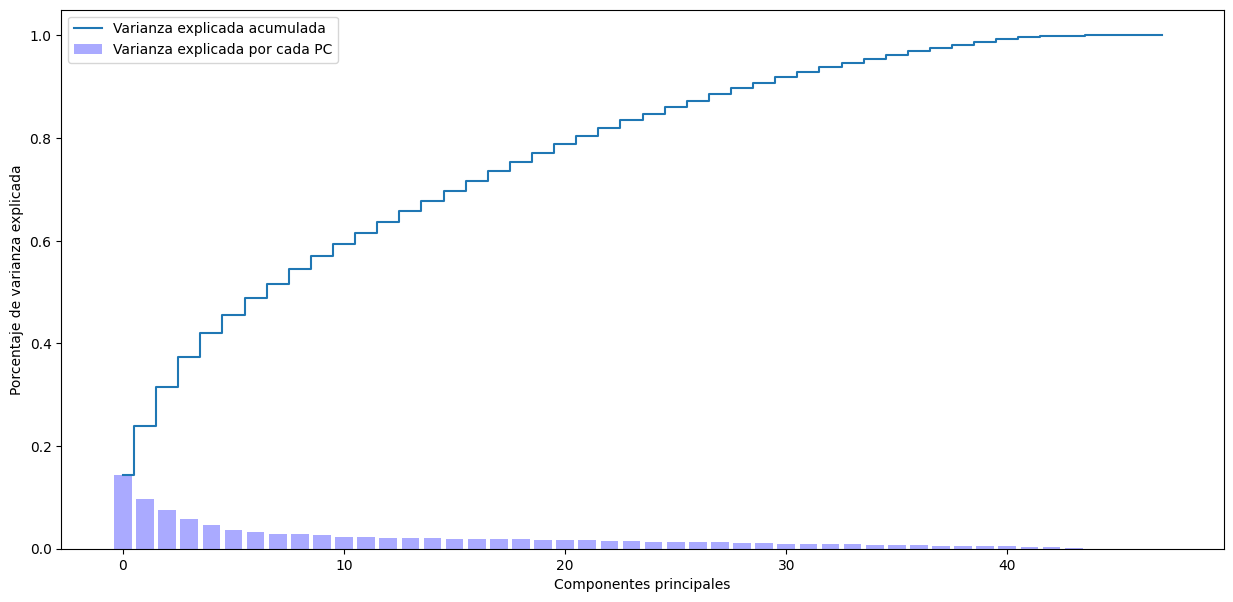

FECHA_CREATININA_EN_SUERO_ORINA_OTROS_LAB     0.864303
FECHA_HDL_LAB                                 0.818434
FECHA_UROANALISIS_LAB                         0.786264
MEDICAMENTOS                                  0.748858
FECHA_ALBUMINURIA_LAB                         0.742431
FECHA_COLESTEROL_TOTAL_LAB                    0.734983
Tiempo_Ultima_cita                            0.722914
FECHA_FOSFORO_LAB                             0.721437
FECHA_CREATININA_24_LAB                       0.714213
SERVICIOS                                     0.713766
FECHA_PROTEINURIA_LAB                         0.713731
MMes_2                                        0.708197
HOSPITALIZACION                               0.707788
TDIASTOLICA                                   0.701453
SMes_3                                        0.689548
FECHA_PTH_LAB                                 0.687988
TSISTOLICA                                    0.686249
FECHA_TRIGLICERIDOS_LAB                       0.675305
FECHA_ULTI

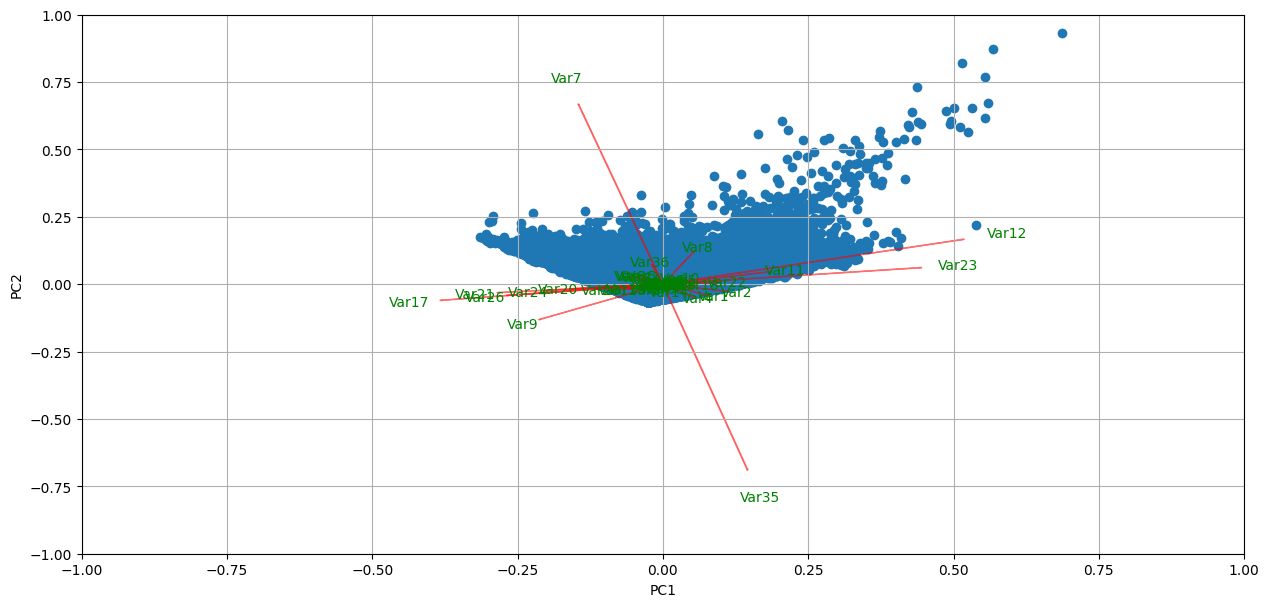

In [23]:
# Uso de la clase
data2 = df[['EDAD', 'TSISTOLICA', 'TDIASTOLICA', 'CMes_6', 'CMes_5', 'CMes_4',
       'CMes_3', 'CMes_2', 'CMes_1', 'SMes_6', 'SMes_5', 'SMes_4', 'SMes_3',
       'SMes_2', 'SMes_1', 'MMes_6', 'MMes_5', 'MMes_4', 'MMes_3', 'MMes_2',
       'MMes_1', 'RIESGOS', 'IV_NIVEL', 'HOSPI_NO_QUIRURGICA',
       'CANTIDAD_URGENCIAS', 'HOSPITALIZACION', 'SERVICIOS', 'MEDICAMENTOS',
       'Antiguedad_paciente', 'Tiempo_Ultima_cita', 'FECHA_ULTIMA_CITA', 'FECHA_ALBUMINA_LAB', 'FECHA_ALBUMINURIA24_LAB', 'FECHA_CREATININA_24_LAB', 'FECHA_CREATININA_DEPURACION_LAB', 'FECHA_FOSFORO_LAB', 'FECHA_HEMOGLOBINA_GLICOSILADA_LAB', 'FECHA_PROTEINURIA_LAB', 'FECHA_PTH_LAB',    
    'FECHA_ALBUMINURIA_LAB', 'FECHA_LDL_LAB',
    'FECHA_COLESTEROL_TOTAL_LAB',
    'FECHA_CREATININA_EN_SUERO_ORINA_OTROS_LAB',
    'FECHA_HDL_LAB',
    'FECHA_HEMOGLOBINA_LAB',
    'FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB',
    'FECHA_TRIGLICERIDOS_LAB',
    'FECHA_UROANALISIS_LAB']]  # Tu data aquí
pca_analysis = PrincipalComponentAnalysis(data2)

pca_analysis.plot_variance_explained()

pca_analysis.biplot(0, 1)

# Obtener las variables más importantes
variables_importantes = pca_analysis.get_most_important_variables()
print(variables_importantes)


Las primeras 20 componentes explican el 80% de la varianza

In [24]:
pca = PrincipalComponentAnalysis(data2)
principal_components = pca.calculate_principal_components()



In [25]:
df_encoded=df_encoded.drop('FECHA_CERO', axis=1)

In [26]:
principal_components= principal_components.iloc[:, :20]
principal_components.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160396 entries, 0 to 160395
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   principal component 1   160396 non-null  float64
 1   principal component 2   160396 non-null  float64
 2   principal component 3   160396 non-null  float64
 3   principal component 4   160396 non-null  float64
 4   principal component 5   160396 non-null  float64
 5   principal component 6   160396 non-null  float64
 6   principal component 7   160396 non-null  float64
 7   principal component 8   160396 non-null  float64
 8   principal component 9   160396 non-null  float64
 9   principal component 10  160396 non-null  float64
 10  principal component 11  160396 non-null  float64
 11  principal component 12  160396 non-null  float64
 12  principal component 13  160396 non-null  float64
 13  principal component 14  160396 non-null  float64
 14  principal component 

## Prueba de importancias con componentes principales PCA

In [27]:
df_encoded1=df_encoded

df_encoded1= pd.concat([ df_encoded1, principal_components ], axis=1)
df_encoded1=df_encoded1.dropna()
X = df_encoded1.drop(columns=['Target','EDAD', 'TSISTOLICA', 'TDIASTOLICA', 'CMes_6', 'CMes_5', 'CMes_4',
       'CMes_3', 'CMes_2', 'CMes_1', 'SMes_6', 'SMes_5', 'SMes_4', 'SMes_3',
       'SMes_2', 'SMes_1', 'MMes_6', 'MMes_5', 'MMes_4', 'MMes_3', 'MMes_2',
       'MMes_1', 'RIESGOS', 'IV_NIVEL', 'HOSPI_NO_QUIRURGICA',
       'CANTIDAD_URGENCIAS', 'HOSPITALIZACION', 'SERVICIOS', 'MEDICAMENTOS',
       'Antiguedad_paciente', 'Tiempo_Ultima_cita', 'FECHA_ULTIMA_CITA', 'FECHA_ALBUMINA_LAB', 'FECHA_ALBUMINURIA24_LAB', 'FECHA_CREATININA_24_LAB', 'FECHA_CREATININA_DEPURACION_LAB', 'FECHA_FOSFORO_LAB', 'FECHA_HEMOGLOBINA_GLICOSILADA_LAB', 'FECHA_PROTEINURIA_LAB', 'FECHA_PTH_LAB',    
    'FECHA_ALBUMINURIA_LAB', 'FECHA_LDL_LAB',
    'FECHA_COLESTEROL_TOTAL_LAB',
    'FECHA_CREATININA_EN_SUERO_ORINA_OTROS_LAB',
    'FECHA_HDL_LAB',
    'FECHA_HEMOGLOBINA_LAB',
    'FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB',
    'FECHA_TRIGLICERIDOS_LAB',
    'FECHA_UROANALISIS_LAB'])

y = df_encoded1['Target']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
#XGBoost Classifier

xgb_classifier = xgb.XGBClassifier()

xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
y_pred = xgb_classifier.predict(X_test)

In [30]:

exactitud = accuracy_score(y_test, y_pred)
print("Exactitud:", exactitud)
# Calcular el índice kappa
kappa = cohen_kappa_score(y_test, y_pred)
print("Índice Kappa:", kappa)
# Calcular el F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

Exactitud: 0.9577458504372658
Índice Kappa: 0.004984975501741595
F1 Score: 0.0062959076600209865


#### Se evidencia que al utilizar las primeras 20 componentes,  y analizar  el F1 score da muy bajo por ende se procede a utilizar modelos de esamble

# Modelos tradicionales 

In [31]:
X = df_encoded.drop(columns=['Target'])  # Características (todas las columnas excepto 'Target')
y = df_encoded['Target']  # Etiquetas de clase (columna 'Target')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




## Random Forest

In [32]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)


In [33]:
from sklearn.metrics import accuracy_score

In [34]:
exactitud = accuracy_score(y_test, y_pred)

print("Exactitud:", exactitud)
from sklearn.metrics import cohen_kappa_score
# Calcular el índice kappa
kappa = cohen_kappa_score(y_test, y_pred)
print("Índice Kappa:", kappa)
from sklearn.metrics import f1_score
# Calcular el F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

Exactitud: 0.9920822942643391
Índice Kappa: 0.9005319209192931
F1 Score: 0.9046546546546547


Con Random Forest se obtuvo un f1_score de 0.90465465465, es un score alto, sin embargo, realizaremos pruebas con más modelos para encontrar el mejor resultado y la mejor selección de variables.
Además las métricas encontradas (Exactitud, Kappa) con este modelo arrojaron valores altos, los cuales concuerdan con el resultado del F1 Score. 

## Feature Importance para Random Forest

In [35]:
importancia_caracteristicas = rf_classifier.feature_importances_
nombres_caracteristicas = X_test.columns
df_importancia_caracteristicas_RF = pd.DataFrame({'Característica': nombres_caracteristicas, 'Importancia_RF': importancia_caracteristicas})
df_importancia_caracteristicas_RF

Característica  Importancia_RF
0                                  EDAD        0.011734
1                            TSISTOLICA        0.008208
2                           TDIASTOLICA        0.007632
3                     FECHA_ULTIMA_CITA        0.106480
4                    FECHA_ALBUMINA_LAB        0.003320
..                                  ...             ...
121  RELACION_ALBUMINURIA_CREATINURIA_1        0.001152
122                     TRIGLICERIDOS_0        0.000589
123                     TRIGLICERIDOS_1        0.000767
124                       UROANALISIS_0        0.001179
125                       UROANALISIS_1        0.001129

[126 rows x 2 columns]

In [36]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

## Modelo XGBOOST

In [37]:
xgb_classifier = xgb.XGBClassifier()

xgb_classifier.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [38]:
y_pred = xgb_classifier.predict(X_test)

In [39]:
exactitud = accuracy_score(y_test, y_pred)
print("Exactitud:", exactitud)
# Calcular el índice kappa
kappa = cohen_kappa_score(y_test, y_pred)
print("Índice Kappa:", kappa)
# Calcular el F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)


Exactitud: 0.9947319201995013
Índice Kappa: 0.9354126688151619
F1 Score: 0.9381631906330039


Con XGBoost se obtuvo un mejor f1_score comparado con Random Forest, el cual arrojó un valor de 0.93816319063. Sin embargo, analizaremos más modelos. Igualmente se obtuvieron métricas con valores altos, las cuales están en concordancia con el F1 Score que se obtuvo. 

## Feature Importance para Random Forest

In [40]:
importancia_caracteristicas = xgb_classifier.feature_importances_
nombres_caracteristicas = X_test.columns
df_importancia_caracteristicas_XG = pd.DataFrame({'Característica': nombres_caracteristicas, 'Importancia_XG': importancia_caracteristicas})

In [41]:
#df_importancia_caracteristicas_XG
df_ordenado_XG = df_importancia_caracteristicas_XG.sort_values(by='Importancia_XG', ascending=False)
df_ordenado_XG

Característica  Importancia_XG
47            Tiempo_Ultima_cita        0.492487
40                      IV_NIVEL        0.063517
3              FECHA_ULTIMA_CITA        0.023470
122              TRIGLICERIDOS_0        0.018163
44                     SERVICIOS        0.016500
..                           ...             ...
55       GRUPO_ETAREO_1 a 4 años        0.000000
91   ENFERMEDAD_RENAL_FAMILIAR_1        0.000000
93                    ALBUMINA_1        0.000000
95                 ALBUMINURIA_1        0.000000
125                UROANALISIS_1        0.000000

[126 rows x 2 columns]

## Modelo  lightgbm

In [43]:
modelo1 = lgb.LGBMClassifier()
modelo1.fit(X_train, y_train)
y_pred = modelo1.predict(X_test)

In [44]:
exactitud = accuracy_score(y_test, y_pred)

print("Exactitud:", exactitud)
# Calcular el índice kappa
kappa = cohen_kappa_score(y_test, y_pred)
print("Índice Kappa:", kappa)

# Calcular el F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)



Exactitud: 0.9944513715710723
Índice Kappa: 0.9320442773737472
F1 Score: 0.9349415204678362


Con XGBOOST se obtuvo un f1_score de 0.93816319063 y con lightgbm de 0.9349415204. Sigue siendo mayor el score que se obtuvo con XGBOOST. Ambos arrojaron métricas cuyos valores son altos y concuerdan con los F1 Score 

## Feature Importance para LIGHTGBM. 

In [45]:
importancia_caracteristicas = modelo1.feature_importances_
nombres_caracteristicas = X_test.columns
df_importancia_caracteristicas_LG = pd.DataFrame({'Característica': nombres_caracteristicas, 'Importancia_LG': importancia_caracteristicas})

## Modelo Catboost

In [46]:
X = df_encoded.drop(columns=['Target'])  
y = df_encoded['Target'] 
# Divide los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea un objeto CatBoostClassifier
model2 = CatBoostClassifier(iterations=1000,  # Número de iteraciones 
                           learning_rate=0.1,  # Tasa de aprendizaje 
                           depth=6,  # Profundidad máxima del árbol
                           verbose=100) 

model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)



0:	learn: 0.5103747	total: 246ms	remaining: 4m 5s
100:	learn: 0.0205284	total: 7.31s	remaining: 1m 5s
200:	learn: 0.0180500	total: 13.9s	remaining: 55.1s
300:	learn: 0.0159543	total: 20.9s	remaining: 48.4s
400:	learn: 0.0143464	total: 27.6s	remaining: 41.3s
500:	learn: 0.0128942	total: 34.5s	remaining: 34.3s
600:	learn: 0.0117738	total: 41.5s	remaining: 27.5s
700:	learn: 0.0106326	total: 48.3s	remaining: 20.6s
800:	learn: 0.0096364	total: 55.4s	remaining: 13.8s
900:	learn: 0.0088546	total: 1m 2s	remaining: 6.82s
999:	learn: 0.0081018	total: 1m 9s	remaining: 0us


In [47]:
#CATBOOST
from sklearn.metrics import accuracy_score

# Calcula la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")
exactitud = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")
print("Exactitud:", exactitud)
# Calcular el índice kappa
kappa = cohen_kappa_score(y_test, y_pred)
print("Índice Kappa:", kappa)
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

Precisión del modelo: 99.50%
Precisión del modelo: 99.50%
Exactitud: 0.9949501246882793
Índice Kappa: 0.9382817976241123
F1 Score: 0.9409190371991247


El mejor f1_score encontrado hasta el momento ha sido con CATBOOST con un valor de 0.940919037199. Las métricas evaluadas en este momento, tales como precisión, exactitud y kappa arrojaron valores altos y congruentes con respecto al F1 Score. 

## Feature Importance CATBOOST. 

In [48]:
importancia_caracteristicas = model2.feature_importances_
nombres_caracteristicas = X_test.columns
df_importancia_caracteristicas_CAT = pd.DataFrame({'Característica': nombres_caracteristicas, 'Importancia_CAT': importancia_caracteristicas})

## Gradient Boosting Classifiers

In [50]:
# Gradient Boosting Classifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")
print("Exactitud:", exactitud)
kappa = cohen_kappa_score(y_test, y_pred)
print("Índice Kappa:", kappa)

f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

Precisión del modelo: 0.9948877805486285
Precisión del modelo: 99.49%
Exactitud: 0.9949501246882793
Índice Kappa: 0.9378227799846911
F1 Score: 0.9404934687953556


In [51]:
df_ordenado_XG = df_importancia_caracteristicas_XG.sort_values(by='Importancia_XG', ascending=False)
df_ordenado_LG = df_importancia_caracteristicas_LG.sort_values(by='Importancia_LG', ascending=False)
df_ordenado_CB = df_importancia_caracteristicas_CAT.sort_values(by='Importancia_CAT', ascending=False)

print(df_ordenado_LG, df_ordenado_XG, df_ordenado_CB )

                  Característica  Importancia_LG
3              FECHA_ULTIMA_CITA             254
46           Antiguedad_paciente             207
47            Tiempo_Ultima_cita             176
20         FECHA_UROANALISIS_LAB             152
0                           EDAD             128
..                           ...             ...
99            COLESTEROL_TOTAL_1               0
100              CREATININA_24_0               0
101              CREATININA_24_1               0
102      CREATININA_DEPURACION_0               0
91   ENFERMEDAD_RENAL_FAMILIAR_1               0

[126 rows x 2 columns]                   Característica  Importancia_XG
47            Tiempo_Ultima_cita        0.492487
40                      IV_NIVEL        0.063517
3              FECHA_ULTIMA_CITA        0.023470
122              TRIGLICERIDOS_0        0.018163
44                     SERVICIOS        0.016500
..                           ...             ...
55       GRUPO_ETAREO_1 a 4 años        0.000

### Selección de Feature Importance con los mejores modelos que se obtuvieron: XGBOOST, LIGHTGBM, CATBOOST. 

In [52]:
df_merged = pd.merge(df_ordenado_XG, df_ordenado_LG, on="Característica", how="inner")
df_merged2 = pd.merge(df_merged, df_ordenado_CB, on="Característica", how="inner")
df_merged2.head(30)

Característica  Importancia_XG  \
0                           Tiempo_Ultima_cita        0.492487   
1                                     IV_NIVEL        0.063517   
2                            FECHA_ULTIMA_CITA        0.023470   
3                              TRIGLICERIDOS_0        0.018163   
4                                    SERVICIOS        0.016500   
5                   FECHA_COLESTEROL_TOTAL_LAB        0.015752   
6                                       AEI_NO        0.009939   
7                                    FOSFORO_0        0.009270   
8                                      RIESGOS        0.009066   
9                              CREATININA_24_0        0.008795   
10                                    GENERO_F        0.008630   
11                         Antiguedad_paciente        0.007281   
12                        ANTIHIPERTENSIVOS_NO        0.006943   
13                               HEMOGLOBINA_0        0.006936   
14                                      SMes_1        0.006685   
15                                  ALBUMINA_0        0.006670   
16                   HEMOGLOBINA_GLICOSILADA_0        0.006108   
17                             ALBUMINURIA24_0        0.006022   
18                                      SMes_2        0.005953   
19                             ESTADO_CIVIL_CA        0.005857   
20                                      MMes_6        0.005829   
21                          FECHA_ALBUMINA_LAB        0.005741   
22                       FECHA_UROANALISIS_LAB        0.005725   
23                     FECHA_ALBUMINURIA24_LAB        0.005705   
24  FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB        0.005546   
25                                      SMes_3        0.005496   
26                                       LDL_0        0.005491   
27                      CANCER_MAMA_FAMILIAR_0        0.005460   
28                               FECHA_LDL_LAB        0.005435   
29                                      CMes_3        0.005311   

    Importancia_LG  Importancia_CAT  
0              176        37.429701  
1                6         0.015623  
2              254        14.748609  
3                1         0.001499  
4               62         0.877282  
5               37         0.627222  
6               73         1.712453  
7                2         0.002515  
8              125         3.164643  
9                0         0.046715  
10              39         0.511046  
11             207         3.177527  
12              23         0.505724  
13               1         0.056986  
14              25         0.103479  
15               1         0.014297  
16               1         0.021476  
17               1         0.038584  
18              13         0.073097  
19               6         0.053465  
20              17         0.222385  
21              41         0.910781  
22             152         2.333720  
23              19         0.203279  
24              75         1.687694  
25              24         0.108758  
26               1         0.021605  
27               8         0.046874  
28              95         1.916323  
29             109         1.276679

In [53]:
df_sorted = df_merged2.sort_values(by=[ "Importancia_XG", "Importancia_LG", "Importancia_CAT"], ascending=[False,  False, False])

In [54]:
datas=pd.DataFrame(df_sorted.head(30))
datas

Característica  Importancia_XG  \
0                           Tiempo_Ultima_cita        0.492487   
1                                     IV_NIVEL        0.063517   
2                            FECHA_ULTIMA_CITA        0.023470   
3                              TRIGLICERIDOS_0        0.018163   
4                                    SERVICIOS        0.016500   
5                   FECHA_COLESTEROL_TOTAL_LAB        0.015752   
6                                       AEI_NO        0.009939   
7                                    FOSFORO_0        0.009270   
8                                      RIESGOS        0.009066   
9                              CREATININA_24_0        0.008795   
10                                    GENERO_F        0.008630   
11                         Antiguedad_paciente        0.007281   
12                        ANTIHIPERTENSIVOS_NO        0.006943   
13                               HEMOGLOBINA_0        0.006936   
14                                      SMes_1        0.006685   
15                                  ALBUMINA_0        0.006670   
16                   HEMOGLOBINA_GLICOSILADA_0        0.006108   
17                             ALBUMINURIA24_0        0.006022   
18                                      SMes_2        0.005953   
19                             ESTADO_CIVIL_CA        0.005857   
20                                      MMes_6        0.005829   
21                          FECHA_ALBUMINA_LAB        0.005741   
22                       FECHA_UROANALISIS_LAB        0.005725   
23                     FECHA_ALBUMINURIA24_LAB        0.005705   
24  FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB        0.005546   
25                                      SMes_3        0.005496   
26                                       LDL_0        0.005491   
27                      CANCER_MAMA_FAMILIAR_0        0.005460   
28                               FECHA_LDL_LAB        0.005435   
29                                      CMes_3        0.005311   

    Importancia_LG  Importancia_CAT  
0              176        37.429701  
1                6         0.015623  
2              254        14.748609  
3                1         0.001499  
4               62         0.877282  
5               37         0.627222  
6               73         1.712453  
7                2         0.002515  
8              125         3.164643  
9                0         0.046715  
10              39         0.511046  
11             207         3.177527  
12              23         0.505724  
13               1         0.056986  
14              25         0.103479  
15               1         0.014297  
16               1         0.021476  
17               1         0.038584  
18              13         0.073097  
19               6         0.053465  
20              17         0.222385  
21              41         0.910781  
22             152         2.333720  
23              19         0.203279  
24              75         1.687694  
25              24         0.108758  
26               1         0.021605  
27               8         0.046874  
28              95         1.916323  
29             109         1.276679

In [55]:
df_ordenado_CB = df_importancia_caracteristicas_CAT.sort_values(by='Importancia_CAT', ascending=False)
variables_de_interes = df_ordenado_CB.iloc[:50, :]


### Feature selection por performance de modelos con los mejores resultados de F1 Score

In [56]:
variables_de_interes["Característica"].unique()

array(['Tiempo_Ultima_cita', 'FECHA_ULTIMA_CITA', 'Antiguedad_paciente',
       'RIESGOS', 'EDAD', 'FECHA_UROANALISIS_LAB',
       'FECHA_HEMOGLOBINA_LAB', 'FECHA_LDL_LAB', 'AEI_NO',
       'FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB', 'CMes_5', 'CMes_1',
       'AEI_SI', 'CMes_6', 'FECHA_HEMOGLOBINA_GLICOSILADA_LAB', 'CMes_2',
       'MEDICAMENTOS', 'CMes_3', 'FECHA_ALBUMINURIA_LAB', 'CMes_4',
       'FECHA_CREATININA_EN_SUERO_ORINA_OTROS_LAB', 'FECHA_ALBUMINA_LAB',
       'TSISTOLICA', 'SERVICIOS', 'TDIASTOLICA',
       'FECHA_CREATININA_DEPURACION_LAB', 'FECHA_COLESTEROL_TOTAL_LAB',
       'FECHA_TRIGLICERIDOS_LAB', 'GENERO_F', 'ANTIHIPERTENSIVOS_NO',
       'FECHA_HDL_LAB', 'FECHA_FOSFORO_LAB', 'ANTIHIPERTENSIVOS_SI',
       'FECHA_PROTEINURIA_LAB', 'FECHA_PTH_LAB', 'ESTADO_CIVIL_SO',
       'GENERO_M', 'MMes_2', 'GRUPO_ETAREO_55 a 59 años', 'SMes_6',
       'MMes_6', 'FECHA_ALBUMINURIA24_LAB', 'HIPERTENSION_FAMILIAR_0',
       'ESTADO_CIVIL_UL', 'MMes_3', 'SMes_5', 'MMes_5', 'SMes

### Prueba de rendimientos de modelos por feature selection

In [57]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['Target'])  # Características (todas las columnas excepto 'Target')
y = df_encoded['Target']  # Etiquetas de clase (columna 'Target')
X=X[['Tiempo_Ultima_cita', 'FECHA_ULTIMA_CITA', 'Antiguedad_paciente',
       'RIESGOS', 'EDAD', 'FECHA_UROANALISIS_LAB',
       'FECHA_HEMOGLOBINA_LAB', 'FECHA_LDL_LAB', 'AEI_NO',
       'FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB', 'CMes_5', 'CMes_1',
       'AEI_SI', 'CMes_6', 'FECHA_HEMOGLOBINA_GLICOSILADA_LAB', 'CMes_2',
       'MEDICAMENTOS', 'CMes_3', 'FECHA_ALBUMINURIA_LAB', 'CMes_4',
       'FECHA_CREATININA_EN_SUERO_ORINA_OTROS_LAB', 'FECHA_ALBUMINA_LAB',
       'TSISTOLICA', 'SERVICIOS', 'TDIASTOLICA',
       'FECHA_CREATININA_DEPURACION_LAB', 'FECHA_COLESTEROL_TOTAL_LAB',
       'FECHA_TRIGLICERIDOS_LAB', 'GENERO_F', 'ANTIHIPERTENSIVOS_NO',
       'FECHA_HDL_LAB', 'FECHA_FOSFORO_LAB', 'ANTIHIPERTENSIVOS_SI',
       'FECHA_PROTEINURIA_LAB', 'FECHA_PTH_LAB', 'ESTADO_CIVIL_SO',
       'GENERO_M', 'MMes_2', 'GRUPO_ETAREO_55 a 59 años', 'SMes_6',
       'MMes_6', 'FECHA_ALBUMINURIA24_LAB', 'HIPERTENSION_FAMILIAR_0',
       'ESTADO_CIVIL_UL', 'MMes_3', 'SMes_5', 'MMes_5', 'SMes_4',
       'GRUPO_ETAREO_65 a 69 años', 'CANTIDAD_URGENCIAS']]




In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [59]:
modelo1 = lgb.LGBMClassifier()
modelo1.fit(X_train, y_train)
y_pred = modelo1.predict(X_test)

In [60]:
exactitud = accuracy_score(y_test, y_pred)

print("Exactitud:", exactitud)
kappa = cohen_kappa_score(y_test, y_pred)
print("Índice Kappa:", kappa)
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

Exactitud: 0.9944513715710723
Índice Kappa: 0.9319493501352661
F1 Score: 0.9348462664714496


## Optimizacion Bayesiana XGboost- top model  

In [96]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)



In [97]:
def objective(params):
    clf = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        gamma=params['gamma'],
        min_child_weight=int(params['min_child_weight']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree']
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return -f1  # El objetivo es maximizar la precisión, por lo que negamos la precisión.

# Define el espacio de búsqueda de hiperparámetros
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'gamma': hp.loguniform('gamma', -5, 0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

# Realiza la optimización bayesiana
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)  # Número de evaluaciones para la optimización

print("Mejores hiperparámetros encontrados:")
print(best)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.003605 seconds
TPE using 0 trials


  1%|          | 1/100 [00:21<34:43, 21.05s/trial, best loss: -0.9372961217832548]

build_posterior_wrapper took 0.004015 seconds
TPE using 1/1 trials with best loss -0.937296


  2%|▏         | 2/100 [00:33<26:01, 15.94s/trial, best loss: -0.9388201019664967]

build_posterior_wrapper took 0.003999 seconds
TPE using 2/2 trials with best loss -0.938820


  3%|▎         | 3/100 [00:53<28:46, 17.80s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.213767 seconds
TPE using 3/3 trials with best loss -0.941133


  4%|▍         | 4/100 [01:00<21:41, 13.55s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003999 seconds
TPE using 4/4 trials with best loss -0.941133


  5%|▌         | 5/100 [01:23<26:41, 16.86s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003803 seconds
TPE using 5/5 trials with best loss -0.941133


  6%|▌         | 6/100 [01:35<23:48, 15.20s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003227 seconds
TPE using 6/6 trials with best loss -0.941133


  7%|▋         | 7/100 [01:51<24:22, 15.73s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003512 seconds
TPE using 7/7 trials with best loss -0.941133


  8%|▊         | 8/100 [02:08<24:31, 15.99s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004019 seconds
TPE using 8/8 trials with best loss -0.941133


  9%|▉         | 9/100 [02:16<20:23, 13.44s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003146 seconds
TPE using 9/9 trials with best loss -0.941133


 10%|█         | 10/100 [02:21<16:13, 10.81s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.005023 seconds
TPE using 10/10 trials with best loss -0.941133


 11%|█         | 11/100 [02:31<15:47, 10.64s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.005046 seconds
TPE using 11/11 trials with best loss -0.941133


 12%|█▏        | 12/100 [02:37<13:34,  9.25s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004000 seconds
TPE using 12/12 trials with best loss -0.941133


 13%|█▎        | 13/100 [02:57<18:09, 12.52s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.002001 seconds
TPE using 13/13 trials with best loss -0.941133


 14%|█▍        | 14/100 [03:07<16:54, 11.79s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003510 seconds
TPE using 14/14 trials with best loss -0.941133


 15%|█▌        | 15/100 [03:21<17:32, 12.38s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004011 seconds
TPE using 15/15 trials with best loss -0.941133


 16%|█▌        | 16/100 [03:30<16:02, 11.46s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004004 seconds
TPE using 16/16 trials with best loss -0.941133


 17%|█▋        | 17/100 [03:39<14:41, 10.62s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003999 seconds
TPE using 17/17 trials with best loss -0.941133


 18%|█▊        | 18/100 [04:11<23:14, 17.00s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003005 seconds
TPE using 18/18 trials with best loss -0.941133


 19%|█▉        | 19/100 [04:36<26:20, 19.52s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.006011 seconds
TPE using 19/19 trials with best loss -0.941133


 20%|██        | 20/100 [04:46<22:04, 16.55s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.002999 seconds
TPE using 20/20 trials with best loss -0.941133


 21%|██        | 21/100 [05:15<26:48, 20.36s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004011 seconds
TPE using 21/21 trials with best loss -0.941133


 22%|██▏       | 22/100 [05:42<29:11, 22.45s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004093 seconds
TPE using 22/22 trials with best loss -0.941133


 23%|██▎       | 23/100 [06:00<26:49, 20.91s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004848 seconds
TPE using 23/23 trials with best loss -0.941133


 24%|██▍       | 24/100 [06:25<28:14, 22.30s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004318 seconds
TPE using 24/24 trials with best loss -0.941133


 25%|██▌       | 25/100 [06:56<31:11, 24.95s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003000 seconds
TPE using 25/25 trials with best loss -0.941133


 26%|██▌       | 26/100 [07:13<27:31, 22.32s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003816 seconds
TPE using 26/26 trials with best loss -0.941133


 27%|██▋       | 27/100 [07:38<28:25, 23.36s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004004 seconds
TPE using 27/27 trials with best loss -0.941133


 28%|██▊       | 28/100 [07:52<24:25, 20.35s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003480 seconds
TPE using 28/28 trials with best loss -0.941133


 29%|██▉       | 29/100 [08:14<24:45, 20.92s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003000 seconds
TPE using 29/29 trials with best loss -0.941133


 30%|███       | 30/100 [08:33<23:49, 20.42s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004646 seconds
TPE using 30/30 trials with best loss -0.941133


 31%|███       | 31/100 [08:47<21:19, 18.54s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004518 seconds
TPE using 31/31 trials with best loss -0.941133


 32%|███▏      | 32/100 [09:09<22:00, 19.42s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004007 seconds
TPE using 32/32 trials with best loss -0.941133


 33%|███▎      | 33/100 [09:41<25:56, 23.23s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004001 seconds
TPE using 33/33 trials with best loss -0.941133


 34%|███▍      | 34/100 [10:02<24:39, 22.41s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004009 seconds
TPE using 34/34 trials with best loss -0.941133


 35%|███▌      | 35/100 [10:24<24:16, 22.40s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004000 seconds
TPE using 35/35 trials with best loss -0.941133


 36%|███▌      | 36/100 [10:32<19:28, 18.26s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004509 seconds
TPE using 36/36 trials with best loss -0.941133


 37%|███▋      | 37/100 [10:45<17:19, 16.51s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.006019 seconds
TPE using 37/37 trials with best loss -0.941133


 38%|███▊      | 38/100 [11:07<18:49, 18.22s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003997 seconds
TPE using 38/38 trials with best loss -0.941133


 39%|███▉      | 39/100 [11:27<18:58, 18.67s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.005819 seconds
TPE using 39/39 trials with best loss -0.941133


 40%|████      | 40/100 [11:47<19:01, 19.03s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003006 seconds
TPE using 40/40 trials with best loss -0.941133


 41%|████      | 41/100 [12:07<19:12, 19.53s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.005526 seconds
TPE using 41/41 trials with best loss -0.941133


 42%|████▏     | 42/100 [12:25<18:18, 18.93s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003002 seconds
TPE using 42/42 trials with best loss -0.941133


 43%|████▎     | 43/100 [12:48<19:14, 20.25s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004358 seconds
TPE using 43/43 trials with best loss -0.941133


 44%|████▍     | 44/100 [12:53<14:40, 15.72s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004098 seconds
TPE using 44/44 trials with best loss -0.941133


 45%|████▌     | 45/100 [13:02<12:29, 13.62s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.005334 seconds
TPE using 45/45 trials with best loss -0.941133


 46%|████▌     | 46/100 [13:17<12:29, 13.89s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003006 seconds
TPE using 46/46 trials with best loss -0.941133


 47%|████▋     | 47/100 [13:34<13:11, 14.94s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004032 seconds
TPE using 47/47 trials with best loss -0.941133


 48%|████▊     | 48/100 [13:53<14:02, 16.20s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004512 seconds
TPE using 48/48 trials with best loss -0.941133


 49%|████▉     | 49/100 [14:10<14:01, 16.49s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004003 seconds
TPE using 49/49 trials with best loss -0.941133


 50%|█████     | 50/100 [14:29<14:13, 17.06s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.004513 seconds
TPE using 50/50 trials with best loss -0.941133


 51%|█████     | 51/100 [14:32<10:36, 12.98s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.005014 seconds
TPE using 51/51 trials with best loss -0.941133


 52%|█████▏    | 52/100 [14:46<10:31, 13.15s/trial, best loss: -0.9411334552102376]

build_posterior_wrapper took 0.003510 seconds
TPE using 52/52 trials with best loss -0.941133


 53%|█████▎    | 53/100 [15:00<10:31, 13.43s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004004 seconds
TPE using 53/53 trials with best loss -0.941818


 54%|█████▍    | 54/100 [15:14<10:28, 13.66s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004021 seconds
TPE using 54/54 trials with best loss -0.941818


 55%|█████▌    | 55/100 [15:27<09:59, 13.31s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.007511 seconds
TPE using 55/55 trials with best loss -0.941818


 56%|█████▌    | 56/100 [15:41<09:59, 13.62s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003321 seconds
TPE using 56/56 trials with best loss -0.941818


 57%|█████▋    | 57/100 [15:53<09:23, 13.11s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004572 seconds
TPE using 57/57 trials with best loss -0.941818


 58%|█████▊    | 58/100 [16:02<08:26, 12.05s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004005 seconds
TPE using 58/58 trials with best loss -0.941818


 59%|█████▉    | 59/100 [16:12<07:41, 11.27s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004002 seconds
TPE using 59/59 trials with best loss -0.941818


 60%|██████    | 60/100 [16:24<07:43, 11.59s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003675 seconds
TPE using 60/60 trials with best loss -0.941818


 61%|██████    | 61/100 [16:35<07:17, 11.21s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004013 seconds
TPE using 61/61 trials with best loss -0.941818


 62%|██████▏   | 62/100 [16:44<06:46, 10.69s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.002999 seconds
TPE using 62/62 trials with best loss -0.941818


 63%|██████▎   | 63/100 [17:02<07:54, 12.83s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003001 seconds
TPE using 63/63 trials with best loss -0.941818


 64%|██████▍   | 64/100 [17:09<06:39, 11.10s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004229 seconds
TPE using 64/64 trials with best loss -0.941818


 65%|██████▌   | 65/100 [17:23<07:03, 12.10s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003007 seconds
TPE using 65/65 trials with best loss -0.941818


 66%|██████▌   | 66/100 [17:42<07:58, 14.09s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003693 seconds
TPE using 66/66 trials with best loss -0.941818


 67%|██████▋   | 67/100 [17:52<07:07, 12.96s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003998 seconds
TPE using 67/67 trials with best loss -0.941818


 68%|██████▊   | 68/100 [18:09<07:30, 14.07s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.002504 seconds
TPE using 68/68 trials with best loss -0.941818


 69%|██████▉   | 69/100 [18:18<06:29, 12.56s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003504 seconds
TPE using 69/69 trials with best loss -0.941818


 70%|███████   | 70/100 [18:31<06:20, 12.67s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003999 seconds
TPE using 70/70 trials with best loss -0.941818


 71%|███████   | 71/100 [18:45<06:17, 13.01s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003556 seconds
TPE using 71/71 trials with best loss -0.941818


 72%|███████▏  | 72/100 [18:58<06:07, 13.13s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.005090 seconds
TPE using 72/72 trials with best loss -0.941818


 73%|███████▎  | 73/100 [19:13<06:10, 13.71s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003548 seconds
TPE using 73/73 trials with best loss -0.941818


 74%|███████▍  | 74/100 [19:40<07:38, 17.65s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.005130 seconds
TPE using 74/74 trials with best loss -0.941818


 75%|███████▌  | 75/100 [20:01<07:42, 18.49s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004010 seconds
TPE using 75/75 trials with best loss -0.941818


 76%|███████▌  | 76/100 [20:22<07:48, 19.53s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004798 seconds
TPE using 76/76 trials with best loss -0.941818


 77%|███████▋  | 77/100 [20:46<07:55, 20.68s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003510 seconds
TPE using 77/77 trials with best loss -0.941818


 78%|███████▊  | 78/100 [21:09<07:53, 21.54s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003507 seconds
TPE using 78/78 trials with best loss -0.941818


 79%|███████▉  | 79/100 [21:19<06:17, 17.96s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004518 seconds
TPE using 79/79 trials with best loss -0.941818


 80%|████████  | 80/100 [21:24<04:40, 14.02s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004469 seconds
TPE using 80/80 trials with best loss -0.941818


 81%|████████  | 81/100 [21:40<04:40, 14.75s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003510 seconds
TPE using 81/81 trials with best loss -0.941818


 82%|████████▏ | 82/100 [22:06<05:23, 17.99s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004509 seconds
TPE using 82/82 trials with best loss -0.941818


 83%|████████▎ | 83/100 [22:28<05:24, 19.12s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.002505 seconds
TPE using 83/83 trials with best loss -0.941818


 84%|████████▍ | 84/100 [22:44<04:51, 18.21s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003290 seconds
TPE using 84/84 trials with best loss -0.941818


 85%|████████▌ | 85/100 [22:55<04:02, 16.14s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004506 seconds
TPE using 85/85 trials with best loss -0.941818


 86%|████████▌ | 86/100 [23:10<03:40, 15.73s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004005 seconds
TPE using 86/86 trials with best loss -0.941818


 87%|████████▋ | 87/100 [23:20<03:04, 14.16s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.002929 seconds
TPE using 87/87 trials with best loss -0.941818


 88%|████████▊ | 88/100 [23:45<03:26, 17.24s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003508 seconds
TPE using 88/88 trials with best loss -0.941818


 89%|████████▉ | 89/100 [24:13<03:47, 20.66s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003509 seconds
TPE using 89/89 trials with best loss -0.941818


 90%|█████████ | 90/100 [24:38<03:39, 21.96s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.004103 seconds
TPE using 90/90 trials with best loss -0.941818


 91%|█████████ | 91/100 [25:05<03:31, 23.46s/trial, best loss: -0.9418181818181819]

build_posterior_wrapper took 0.003540 seconds
TPE using 91/91 trials with best loss -0.941818


 92%|█████████▏| 92/100 [25:41<03:37, 27.13s/trial, best loss: -0.942034269048487] 

build_posterior_wrapper took 0.005010 seconds
TPE using 92/92 trials with best loss -0.942034


 93%|█████████▎| 93/100 [25:56<02:44, 23.51s/trial, best loss: -0.942034269048487]

build_posterior_wrapper took 0.003000 seconds
TPE using 93/93 trials with best loss -0.942034


 94%|█████████▍| 94/100 [26:15<02:13, 22.17s/trial, best loss: -0.942034269048487]

build_posterior_wrapper took 0.005524 seconds
TPE using 94/94 trials with best loss -0.942034


 95%|█████████▌| 95/100 [26:27<01:36, 19.23s/trial, best loss: -0.942034269048487]

build_posterior_wrapper took 0.004662 seconds
TPE using 95/95 trials with best loss -0.942034


 96%|█████████▌| 96/100 [26:42<01:11, 17.92s/trial, best loss: -0.942034269048487]

build_posterior_wrapper took 0.005128 seconds
TPE using 96/96 trials with best loss -0.942034


 97%|█████████▋| 97/100 [26:57<00:50, 17.00s/trial, best loss: -0.942034269048487]

build_posterior_wrapper took 0.007919 seconds
TPE using 97/97 trials with best loss -0.942034


 98%|█████████▊| 98/100 [27:41<00:50, 25.04s/trial, best loss: -0.942034269048487]

build_posterior_wrapper took 0.004950 seconds
TPE using 98/98 trials with best loss -0.942034


 99%|█████████▉| 99/100 [27:51<00:20, 20.58s/trial, best loss: -0.942034269048487]

build_posterior_wrapper took 0.005908 seconds
TPE using 99/99 trials with best loss -0.942034


100%|██████████| 100/100 [28:14<00:00, 16.95s/trial, best loss: -0.942034269048487]
Mejores hiperparámetros encontrados:
{'colsample_bytree': 0.8594132045977992, 'gamma': 0.42187149198555784, 'learning_rate': 0.04671330575860237, 'max_depth': 9.0, 'min_child_weight': 2.0, 'n_estimators': 170.0, 'subsample': 0.7802187260223723}


In [105]:
# Definir los hiperparámetros proporcionados
params = {
    'colsample_bytree': 0.7642749525499422,
    'gamma': 0.0937927168915684,
    'learning_rate': 0.14543023999702792,
    'max_depth': 9,
    'min_child_weight': 3,
    'n_estimators': 180,
    'subsample': 0.9986427975146679
}

xgb_classifier1 = xgb.XGBClassifier(**params)
xgb_classifier1.fit(X_train, y_train)
# Definir el umbral (threshold)
 # Puedes ajustar este valor según tus necesidades
y_test = xgb_classifier.predict(X_test)

# Calcular el F1 score en los datos de prueba
f1 = f1_score(y_test, y_pred)

# Imprimir el F1 score
print("F1 Score:", f1)

F1 Score: 0.9903489235337788


In [146]:
# Función para encontrar el umbral óptimo
def find_optimal_threshold(model, X, y, threshold_range=(0.1, 0.9), threshold_steps=9):
    # Entrenar el modelo XGBoost
    model.fit(X, y)

    # Obtener las probabilidades de predicción en el conjunto de entrenamiento
    y_prob = model.predict_proba(X)

    # Definir una lista de umbrales para probar
    thresholds = np.linspace(threshold_range[0], threshold_range[1], threshold_steps)
    best_threshold = 0
    best_f1 = 0

    for threshold in thresholds:
    
        y_pred = (y_prob[:, 1] > threshold).astype(int)
       
        f1 = f1_score(y, y_pred)

        # Actualiza el umbral óptimo si se encuentra un F1 score más alto
        if f1 > best_f1:
            best_threshold = threshold
            best_f1 = f1

    return best_threshold, best_f1

best_threshold, best_f1 = find_optimal_threshold(xgb.XGBClassifier(), X_train, y_train)

print("Umbral óptimo:", best_threshold)
print("F1 score máximo en entrenamiento:", best_f1)


Umbral óptimo: 0.4
F1 score máximo en entrenamiento: 0.9832236537213829


In [150]:
y_proba = xgb_classifier.predict_proba(X_test)[:, 1]
threshold = 0.4  
y_pred = (y_proba > threshold).astype(int)
exactitud = accuracy_score(y_test, y_pred)
print("Exactitud:", exactitud)
kappa = cohen_kappa_score(y_test, y_pred)
print("Índice Kappa:", kappa)
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)


Exactitud: 0.9996882793017456
Índice Kappa: 0.9961390594291426
F1 Score: 0.9963017751479291


In [149]:
exactitud = accuracy_score(y_test, y_pred)

print("Exactitud:", exactitud)
kappa = cohen_kappa_score(y_test, y_pred)
print("Índice Kappa:", kappa)
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

Exactitud: 0.9991895261845386
Índice Kappa: 0.9899259254535393
F1 Score: 0.9903489235337788


## Modelo Catboost para seleccion de variables

In [62]:
modelcat = CatBoostClassifier(iterations=500, depth=10, learning_rate=0.05, loss_function='Logloss')

# Entrenar el modelo
modelcat.fit(X_train, y_train)
y_pred = modelcat.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

0:	learn: 0.5938309	total: 283ms	remaining: 2m 21s
1:	learn: 0.5140738	total: 363ms	remaining: 1m 30s
2:	learn: 0.4415325	total: 627ms	remaining: 1m 43s
3:	learn: 0.3463484	total: 904ms	remaining: 1m 52s
4:	learn: 0.2978900	total: 1.18s	remaining: 1m 56s
5:	learn: 0.2401967	total: 1.45s	remaining: 1m 59s
6:	learn: 0.1948462	total: 1.72s	remaining: 2m 1s
7:	learn: 0.1607163	total: 2s	remaining: 2m 3s
8:	learn: 0.1336432	total: 2.27s	remaining: 2m 4s
9:	learn: 0.1119343	total: 2.55s	remaining: 2m 4s
10:	learn: 0.0959041	total: 2.82s	remaining: 2m 5s
11:	learn: 0.0828604	total: 3.1s	remaining: 2m 5s
12:	learn: 0.0721649	total: 3.37s	remaining: 2m 6s
13:	learn: 0.0642880	total: 3.64s	remaining: 2m 6s
14:	learn: 0.0574031	total: 3.91s	remaining: 2m 6s
15:	learn: 0.0521042	total: 4.18s	remaining: 2m 6s
16:	learn: 0.0487378	total: 4.46s	remaining: 2m 6s
17:	learn: 0.0448565	total: 4.7s	remaining: 2m 5s
18:	learn: 0.0417991	total: 4.94s	remaining: 2m 5s
19:	learn: 0.0394381	total: 5.19s	remain

### Los resultados que se obtuvieron de acuerdo a los modelos con la selección de variables fueron: 
- XGBOOST: F1 Score: 0.9381631906330039, XGBOOST con selección de variables y optimización Bayesiana obtuvo un F1 Score de: 0.9903489235337788, aumentó considerablemente con respecto al modelo sin selcción de variables. Hasta el momento ha sido el mejor score encontrado. XGBoost es un modelo robusto y efectivo para tareas de clasificación. 
- LIGHTGBM: F1 Score: 0.9349415204678362, LIGHTGBM con selección de variables, F1 Score: 0.9348462664714496, disminuyó. 
- CATBOOST: F1 Score: 0.9409190371991247, CATBOOST con selección de variables, F1 Score: 0.9392506365, disminuyó. 
- Los resultados de las métricas encontradas para estos modelos con respecto a la selección de variables arrojaron valores congruentes dados los valores de f1 score obtenidos. 

### SUBMISSION

In [106]:
import os.path as osp 
import os

In [151]:
DATA_DIR = "/kaggle/input/fa-ii-2023-ii-flujos-de-modelos-tradicionales/"
test_df = pd.read_parquet(osp.join("df_test.parquet"))

In [152]:
##test_df["Target"]=df1["Target"].astype(object)
test_df["TSISTOLICA"]=test_df["TSISTOLICA"].astype(float)
test_df["TDIASTOLICA"]=test_df["TDIASTOLICA"].astype(float)

In [153]:
test_df['TSISTOLICA'].describe()

count    57866.000000
mean       126.317026
std         57.120031
min          0.000000
25%        120.000000
50%        120.000000
75%        130.000000
max      13200.000000
Name: TSISTOLICA, dtype: float64

In [154]:
outliersdata= ['EDAD', 'TSISTOLICA', 'TDIASTOLICA']
outliersdata

['EDAD', 'TSISTOLICA', 'TDIASTOLICA']

In [155]:
import pandas as pd

def imputar_outliers_iqr_en_df(df, outliersdata):
    """
    Imputa los outliers de cada columna numérica contenida en var_numericas1 de un DataFrame
    con los valores mínimos y máximos de los límites intercuartiles (IQR).

    Args:
    df (pd.DataFrame): El DataFrame que contiene los datos y se modificará.
    var_numericas1 (list): Una lista de nombres de columnas numéricas en el DataFrame para la imputación de outliers.

    Returns:
    None
    """
    for columna in outliersdata:
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.85)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[columna] = df[columna].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# Ejemplo de uso:
# imputar_outliers_iqr_en_df(df, var_numericas1)


In [156]:
imputar_outliers_iqr_en_df(test_df, outliersdata)

In [157]:
test_df['EDAD'].describe()

count    68742.000000
mean        64.560851
std         13.705089
min         21.500000
25%         56.000000
50%         65.000000
75%         74.000000
max        107.000000
Name: EDAD, dtype: float64

In [158]:
def process_columns(dataset):
    # Copia el dataset original para no modificarlo directamente
    data = dataset.copy()
    
    # Selecciona las columnas del índice 20 al 53
    selected_columns = data.iloc[:, 20:54]
    
    # Itera a través de las columnas seleccionadas
    for col in selected_columns.columns:
        # Verifica si la columna no es de tipo datetime
        if not pd.api.types.is_datetime64_any_dtype(selected_columns[col]):
            # Reemplaza los valores nulos por 0
            selected_columns[col].fillna(0, inplace=True)
    
    # Actualiza las columnas seleccionadas en el dataset original
    data.iloc[:, 20:54] = selected_columns
    
    return data

In [159]:
test_df=process_columns(test_df)


In [160]:
test_df['FECHA_CERO'] = pd.to_datetime(test_df['FECHA_CERO'], format='%Y%m%d', errors='coerce')


# Lista de columnas de fechas
columnas_fechas = ['FECHA_ULTIMA_CITA', 'FECHA_ALBUMINA_LAB', 'FECHA_ALBUMINURIA24_LAB', 'FECHA_CREATININA_24_LAB', 'FECHA_CREATININA_DEPURACION_LAB', 'FECHA_FOSFORO_LAB', 'FECHA_HEMOGLOBINA_GLICOSILADA_LAB', 'FECHA_PROTEINURIA_LAB', 'FECHA_PTH_LAB',    
    'FECHA_ALBUMINURIA_LAB', 'FECHA_LDL_LAB',
    'FECHA_COLESTEROL_TOTAL_LAB',
    'FECHA_CREATININA_EN_SUERO_ORINA_OTROS_LAB',
    'FECHA_HDL_LAB',
    'FECHA_HEMOGLOBINA_LAB',
    'FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB',
    'FECHA_TRIGLICERIDOS_LAB',
    'FECHA_UROANALISIS_LAB']

# Convierte las columnas de fechas al formato datetime
for columna in columnas_fechas:
    test_df[columna] = pd.to_datetime(test_df[columna], format='%Y%m%d', errors='coerce')
 

In [161]:
# Calcula la distancia en días y reemplaza las fechas por los valores de días
for columna in columnas_fechas:
    test_df[columna] = (test_df['FECHA_CERO'] - test_df[columna]).dt.days




In [162]:
test_df=test_df.drop('FECHA_CERO', axis=1)
columnas_categoricas = [col for col in test_df.columns if test_df[col].dtype == 'object']

# Aplica la codificación one-hot solo a las variables categóricas
df_encoded_test_df = pd.get_dummies(test_df, columns=columnas_categoricas)

In [163]:
df_encoded_test_df=df_encoded_test_df.fillna(0)

In [164]:
df_encoded_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68742 entries, 105055 to 170397
Columns: 127 entries, EDAD to UROANALISIS_1
dtypes: float64(48), uint8(79)
memory usage: 30.9 MB


In [165]:
columnas_faltantes_en_df2 = set(X_train.columns) - set(df_encoded_test_df.columns)
columnas_faltantes_en_df2 

set()

In [166]:
=df_encoded_test_df[['Tiempo_Ultima_cita', 'FECHA_ULTIMA_CITA', 'Antiguedad_paciente',
       'RIESGOS', 'EDAD', 'FECHA_UROANALISIS_LAB',
       'FECHA_HEMOGLOBINA_LAB', 'FECHA_LDL_LAB', 'AEI_NO',
       'FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB', 'CMes_5', 'CMes_1',
       'AEI_SI', 'CMes_6', 'FECHA_HEMOGLOBINA_GLICOSILADA_LAB', 'CMes_2',
       'MEDICAMENTOS', 'CMes_3', 'FECHA_ALBUMINURIA_LAB', 'CMes_4',
       'FECHA_CREATININA_EN_SUERO_ORINA_OTROS_LAB', 'FECHA_ALBUMINA_LAB',
       'TSISTOLICA', 'SERVICIOS', 'TDIASTOLICA',
       'FECHA_CREATININA_DEPURACION_LAB', 'FECHA_COLESTEROL_TOTAL_LAB',
       'FECHA_TRIGLICERIDOS_LAB', 'GENERO_F', 'ANTIHIPERTENSIVOS_NO',
       'FECHA_HDL_LAB', 'FECHA_FOSFORO_LAB', 'ANTIHIPERTENSIVOS_SI',
       'FECHA_PROTEINURIA_LAB', 'FECHA_PTH_LAB', 'ESTADO_CIVIL_SO',
       'GENERO_M', 'MMes_2', 'GRUPO_ETAREO_55 a 59 años', 'SMes_6',
       'MMes_6', 'FECHA_ALBUMINURIA24_LAB', 'HIPERTENSION_FAMILIAR_0',
       'ESTADO_CIVIL_UL', 'MMes_3', 'SMes_5', 'MMes_5', 'SMes_4',
       'GRUPO_ETAREO_65 a 69 años', 'CANTIDAD_URGENCIAS'
   

]]

In [167]:
y_proba = xgb_classifier.predict_proba(test_df)[:, 1]

threshold = 0.4 

y_pred = (y_proba > threshold).astype(int)

In [168]:
submission_pred = y_pred 

In [169]:
pd.DataFrame(submission_pred)

0
0      0
1      0
2      0
3      0
4      0
...   ..
68737  0
68738  0
68739  0
68740  0
68741  0

[68742 rows x 1 columns]

In [170]:
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred))

In [171]:
submission.to_csv("submission.csv", index=False)

In [172]:
submission["Target"].value_counts()

0    65828
1     2914
Name: Target, dtype: int64

# Support vector Machine 

In [63]:
# Lista de nombres de columnas a seleccionar
columnas_a_seleccionar = ['Tiempo_Ultima_cita', 'FECHA_ULTIMA_CITA', 'Antiguedad_paciente', 'RIESGOS', 'EDAD', 'FECHA_UROANALISIS_LAB', 'FECHA_HEMOGLOBINA_LAB', 'FECHA_LDL_LAB','AEI_NO', 'FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB', 'CMes_5', 'CMes_1', 'AEI_SI', 'CMes_6', 'FECHA_HEMOGLOBINA_GLICOSILADA_LAB', 'CMes_2', 'MEDICAMENTOS', 'CMes_3', 'FECHA_ALBUMINURIA_LAB', 'CMes_4', 'FECHA_CREATININA_EN_SUERO_ORINA_OTROS_LAB', 'FECHA_ALBUMINA_LAB', 'TSISTOLICA', 'SERVICIOS', 'TDIASTOLICA', 'FECHA_CREATININA_DEPURACION_LAB', 'FECHA_COLESTEROL_TOTAL_LAB', 'FECHA_TRIGLICERIDOS_LAB', 'FECHA_HDL_LAB', 'FECHA_FOSFORO_LAB', 'FECHA_PROTEINURIA_LAB', 'FECHA_PTH_LAB', 'MMes_2', 'SMes_6', 'MMes_6', 'FECHA_ALBUMINURIA24_LAB',  'MMes_3', 'SMes_5', 'MMes_5', 'SMes_4',  'CANTIDAD_URGENCIAS', 'IV_NIVEL']
df2 = df_encoded[columnas_a_seleccionar]
scaler = StandardScaler()
df2_normalized = scaler.fit_transform(df2)
df_encoded[columnas_a_seleccionar] = df2_normalized


In [64]:
df_sampled = df_encoded.sample(n=30000, random_state=42)
X = df_sampled.drop(columns=['Target'])
y = df_sampled['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



SVM

In [187]:
metrica = 'accuracy'
steps = [("SVM_linear", SVC(kernel="linear", probability=True))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10]}
grid1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid1.fit(X_train, y_train)
y_pred=grid1.predict(X_test)
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
# Print the Kappa score
print("Cohen's Kappa:", kappa)
print("F1 Score:", f1)
print("score = %3.4f" %(grid1.score(X_test,y_test)))
print(grid1.best_params_)

Cohen's Kappa: 0.7407663440647838
F1 Score: 0.75
score = 0.9813
{'SVM_linear__C': 1}


En el caso del modelo de Support Vector Machine con la función kernel lineal, se logra un impresionante valor de precisión (Accuracy) de 0.9813. Sin embargo, el puntaje F1 se sitúa en 0.75, lo cual, comparado con nuestros modelos previos, revela un margen de mejora en estas condiciones específicas.

In [190]:
steps = [("SVM_rbf", SVC(kernel="rbf", probability=True))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10], 'SVM_rbf__gamma':[0.05,0.01, 1, 5]}
grid2 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid2.fit(X_train, y_train)
y_pred=grid2.predict(X_test)
print("score = %3.4f" %(grid2.score(X_test,y_test)))
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
# Print the Kappa score
print("Cohen's Kappa:", kappa)
print("F1 Score:", f1)
print(grid2.best_params_)

score = 0.9680
Cohen's Kappa: 0.5235069885641677
F1 Score: 0.5384615384615384
{'SVM_rbf__C': 10, 'SVM_rbf__gamma': 0.01}


Los resultados obtenidos con el modelo de Support Vector Machine utilizando la función de kernel RBF muestran un impresionante índice de precisión de 0.96. Sin embargo, al profundizar en la métrica objetivo de este ejercicio, el puntaje F1 es de 0.53. Por lo tanto, aunque el modelo muestra un alto nivel de precisión, no se considera definitivo debido a que los modelos de ensamble que hemos entrenado han arrojado métricas más favorables.

In [191]:
steps = [("SVM_sigmoid", SVC(kernel="sigmoid", probability=True))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5]}
grid3 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid3.fit(X_train, y_train)
y_pred=grid3.predict(X_test)
print("score = %3.4f" %(grid3.score(X_test,y_test)))
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
# Print the Kappa score
print("Cohen's Kappa:", kappa)
print("F1 Score:", f1)
print(grid2.best_params_)

score = 0.9547
Cohen's Kappa: 0.0
F1 Score: 0.0
{'SVM_rbf__C': 10, 'SVM_rbf__gamma': 0.01}


Al examinar los resultados del modelo de clasificación con Support Vector Machine utilizando la función sigmoide, se observa una ligera disminución del 0.01 en la precisión en comparación con la función RBF. Sin embargo, al analizar el puntaje F1, se aprecia una notable reducción exponencial hasta alcanzar un valor de 0. Esto indica que la elección de la función sigmoide ha tenido un impacto significativo en el desempeño del modelo, lo que requiere una evaluación más detenida.

In [192]:
y_train_score1 = grid1.predict_proba(X_train)[:,1]
y_test_score1 = grid1.predict_proba(X_test)[:,1]
y_train_score2 = grid2.predict_proba(X_train)[:,1]
y_test_score2 = grid2.predict_proba(X_test)[:,1]
y_train_score3 = grid3.predict_proba(X_train)[:,1]
y_test_score3 = grid3.predict_proba(X_test)[:,1]

In [193]:
false_pos_rate3, true_pos_rate3, _ = roc_curve(y_train, y_train_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)
false_pos_rate3_test, true_pos_rate3_test, _ = roc_curve(y_test, y_test_score3)
roc_auc3_test = auc(false_pos_rate3_test, true_pos_rate3_test)

false_pos_rate2, true_pos_rate2, _ = roc_curve(y_train, y_train_score2)
roc_auc2 = auc(false_pos_rate2, true_pos_rate2)
false_pos_rate2_test, true_pos_rate2_test, _ = roc_curve(y_test, y_test_score2)
roc_auc2_test = auc(false_pos_rate2_test, true_pos_rate2_test)

false_pos_rate1, true_pos_rate1, _ = roc_curve(y_train, y_train_score1)
roc_auc1 = auc(false_pos_rate1, true_pos_rate1)
false_pos_rate1_test, true_pos_rate1_test, _ = roc_curve(y_test, y_test_score1)
roc_auc1_test = auc(false_pos_rate1_test, true_pos_rate1_test)





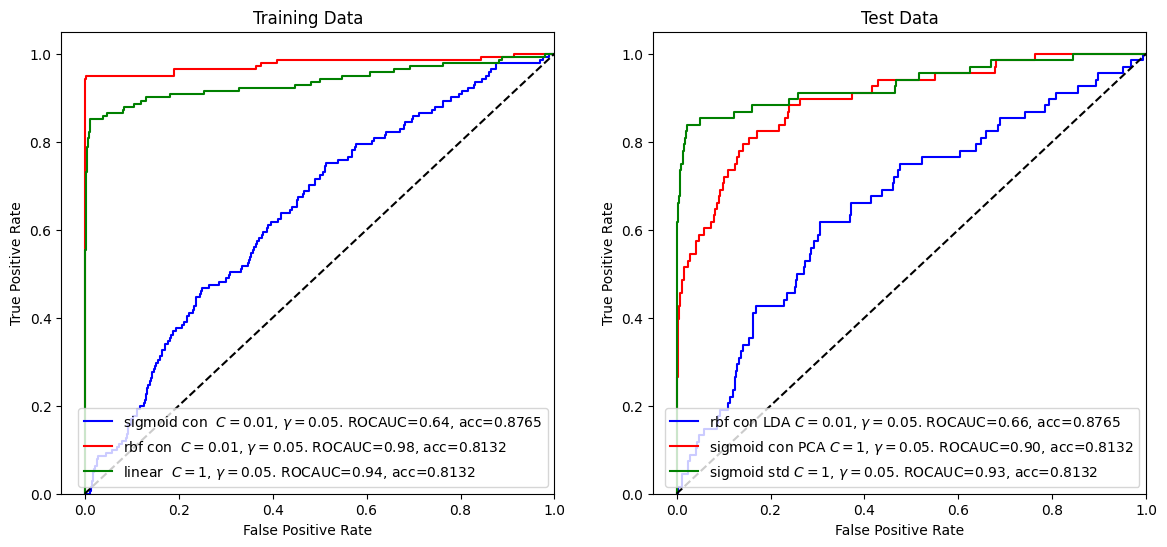

In [194]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(false_pos_rate3, true_pos_rate3, label='sigmoid con  $C=0.01$, $\gamma=0.05$. ROCAUC=%0.2f, acc=0.8765' % roc_auc3, color='b')
ax1.plot(false_pos_rate2, true_pos_rate2, label='rbf con  $C=0.01$, $\gamma=0.05$. ROCAUC=%0.2f, acc=0.8132' % roc_auc2, color='r')
ax1.plot(false_pos_rate1, true_pos_rate1, label='linear  $C=1$, $\gamma=0.05$. ROCAUC=%0.2f, acc=0.8132' % roc_auc1, color='g')
ax1.set_title('Training Data')

ax2.plot(false_pos_rate3_test, true_pos_rate3_test, label='rbf con LDA $C=0.01$, $\gamma=0.05$. ROCAUC=%0.2f, acc=0.8765' % roc_auc3_test, color='b')
ax2.plot(false_pos_rate2_test, true_pos_rate2_test, label='sigmoid con PCA $C=1$, $\gamma=0.05$. ROCAUC=%0.2f, acc=0.8132' % roc_auc2_test, color='r')
ax2.plot(false_pos_rate1_test, true_pos_rate1_test, label='sigmoid std $C=1$, $\gamma=0.05$. ROCAUC=%0.2f, acc=0.8132' % roc_auc1_test, color='g')
ax2.set_title('Test Data')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

Considerando las curvas ROC de los modelos de Support Vector Machine (SVM), se destaca que la curva correspondiente al kernel RBF presenta un área bajo la curva (AUC) superior, indicando un rendimiento generalmente sólido en términos de la tasa de verdaderos positivos frente a la tasa de falsos positivos. Sin embargo, al examinar el valor del F-score, se observa que el modelo con kernel lineal parece lograr un mejor ajuste y se adapta de manera más coherente a los requisitos específicos de nuestro ejercicio. Por otro lado, la capacidad discriminatoria de la función kernel sigmoide parece ser considerablemente baja, lo que sugiere que este modelo podría no ser adecuado para la tarea dada.

### Optimización Bayesiana para SPVM con kernell Lineal   (mejores resultados)

In [102]:
!pip install bayesian-optimization
#conda install -c conda-forge bayesian-optimization

In [230]:
from sklearn.metrics import f1_score

def entrenar_svc(num_pca, svm_c, svm_rbf_gamma):
    num_pca = int(round(num_pca))
    steps = [('STD', StandardScaler()),
             ('PCA', PCA(n_components=num_pca)),
             ("SVM_lineal", SVC(kernel="linear", probability=True, C=svm_c, gamma=svm_rbf_gamma))]
    pipeline = Pipeline(steps)
    pipeline.fit(X_train, y_train)
    f1 = f1_score(y_test, y_pred)
    

    score = pipeline.score(X_test,y_test)
    print(f"Evaluando (pca={num_pca}, C={svm_c}, svm_lineal_gamma={svm_rbf_gamma}): {score}")
    print(f1)
    return score

In [231]:
entrenar_svc(num_pca=15, svm_c=0.1, svm_rbf_gamma=0.01)

Evaluando (pca=15, C=0.1, svm_lineal_gamma=0.01): 0.998
0.0


0.998

In [232]:
pbounds = {'num_pca': (2, 10), 'svm_c': (0.001, 1), 'svm_rbf_gamma':(0.001, 0.1) }

In [233]:
from bayes_opt import BayesianOptimization

In [234]:
np.random.seed(42)
optimizer = BayesianOptimization(
    f=entrenar_svc,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [235]:
%%time
optimizer.maximize(
    init_points=5,
    n_iter=30,
)

|   iter    |  target   |  num_pca  |   svm_c   | svm_rb... |
-------------------------------------------------------------
Evaluando (pca=5, C=0.7206041689487159, svm_lineal_gamma=0.0010113231069171437): 0.998
0.0
| 1         | 0.998     | 5.336     | 0.7206    | 0.001011  |
Evaluando (pca=4, C=0.14760913492629593, svm_lineal_gamma=0.010141520882110983): 0.998
0.0
| 2         | 0.998     | 4.419     | 0.1476    | 0.01014   |
Evaluando (pca=3, C=0.3462151663160047, svm_lineal_gamma=0.04027997994883633): 0.998
0.0
| 3         | 0.998     | 3.49      | 0.3462    | 0.04028   |
Evaluando (pca=6, C=0.4197753198888915, svm_lineal_gamma=0.06883673053927919): 0.998
0.0
| 4         | 0.998     | 6.311     | 0.4198    | 0.06884   |
Evaluando (pca=4, C=0.8782393189545544, svm_lineal_gamma=0.0037113717265946904): 0.998
0.0
| 5         | 0.998     | 3.636     | 0.8782    | 0.003711  |
Evaluando (pca=10, C=0.9644678479280215, svm_lineal_gamma=0.007707607630997822): 0.998
0.0
| 6         | 0.998     

In [236]:
optimizer.max

{'target': 0.998,
 'params': {'num_pca': 5.336176037620592,
  'svm_c': 0.7206041689487159,
  'svm_rbf_gamma': 0.0010113231069171437}}

Luego de llevar a cabo la optimización bayesiana, se destacan los siguientes hiperparámetros como los más prometedores para obtener un rendimiento óptimo en las Máquinas de Soporte Vectorial:

- Precisión del modelo: 0.998
 Hiperparámetros óptimos:
- Número de componentes principales (PCA): 5
- Parámetro C del SVM: 0.720604168948715
- Parámetro gamma del kernel lienal del SVM: 0.0010113231069171437

Mas adelante se vuelve a ejecutar por sugerencia en clase por el  profesor.

In [237]:
pbounds = {'num_pca': (2, 8), 'svm_c': (0.1, 10), 'svm_rbf_gamma':(0.001, 0.1) }
optimizer.set_bounds(pbounds)

In [238]:
%%time
optimizer.maximize(
    init_points=5,
    n_iter=30,
)

|   iter    |  target   |  num_pca  |   svm_c   | svm_rb... |
-------------------------------------------------------------
Evaluando (pca=6, C=4.231317543434557, svm_lineal_gamma=0.056310293016129415): 0.998
0.0
| 36        | 0.998     | 6.023     | 4.231     | 0.05631   |
Evaluando (pca=3, C=2.0612047419403, svm_lineal_gamma=0.08027371229887814): 0.998
0.0
| 37        | 0.998     | 2.842     | 2.061     | 0.08027   |
Evaluando (pca=8, C=3.2028993637765044, svm_lineal_gamma=0.06953993895126209): 0.998
0.0
| 38        | 0.998     | 7.81      | 3.203     | 0.06954   |
Evaluando (pca=7, C=8.956605968688088, svm_lineal_gamma=0.009419376925608014): 0.998
0.0
| 39        | 0.998     | 7.258     | 8.957     | 0.009419  |
Evaluando (pca=2, C=1.7813211536892324, svm_lineal_gamma=0.0879361078395119): 0.998
0.0
| 40        | 0.998     | 2.234     | 1.781     | 0.08794   |
Evaluando (pca=2, C=9.981507211870275, svm_lineal_gamma=0.06836684404167633): 0.998
0.0
| 41        | 0.998     | 2.105     |

In [239]:
optimizer.max

{'target': 0.998,
 'params': {'num_pca': 5.336176037620592,
  'svm_c': 0.7206041689487159,
  'svm_rbf_gamma': 0.0010113231069171437}}

In [254]:
steps = [('STD', StandardScaler()), ('PCA', PCA(n_components=5)),
         ("SVM_rbf", SVC(kernel="linear", probability=True, C= 0.7206041689487159, gamma=0.0010113231069171437))]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
y_test=pipeline.predict(X_test)

In [261]:
np.unique(y_test)

array([0], dtype=int64)

In [255]:
from sklearn.metrics import f1_score

# Calcular el F1-score
f1 = f1_score(y_test, y_pred)

print("F1-score:", f1)

F1-score: 0.0


Se puede notar que durante la segunda iteración del proceso de optimización bayesiana, los hiperparámetros que exhiben un mejor rendimiento son los siguientes:

- Para la estandarización de datos, se emplea StandardScaler().
- Para la reducción de dimensionalidad, se utiliza PCA con 5 componentes.
-  En cuanto al modelo SVM con kernel RBF, se ajusta con los siguientes hiperparámetros: C=0.7206041689487159 y gamma=0.0010113231069171437, habilitando la opción de probabilidad (probability=True).

## Redes Neuronales

In [68]:
import numpy as np
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import cross_val_score, cross_validate #método para evaluar varios particionamientos de C-V
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, LeaveOneOut #Iteradores de C-V
from sklearn.model_selection import GridSearchCV #permite buscar la mejor configuración de parámetros con C-V
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
from sklearn.metrics import make_scorer # permite crear una clase scorer a partir de una función de score (necesario para el kappa)
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

In [69]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05]

In [70]:
mlp = MLPClassifier()

In [291]:
import time
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

np.random.seed(1234)

parametros = {'activation': activation_vec}

scoring = {'f1_score': make_scorer(f1_score)}

grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='f1_score', n_jobs=-1)

grid.fit(X_train, y_train)

best_params = grid.best_params_
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)


print("Best Parameters:", best_params)



Best Parameters: {'activation': 'logistic'}


C:\Users\fmaur\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [292]:
import time
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

# Establecer la semilla aleatoria
np.random.seed(1234)

# Definir los parámetros que deseas ajustar
parametros = {'activation': activation_vec}

scoring = {'accuracy': make_scorer(accuracy_score)}

grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1)

grid.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid.best_params_
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

# Calcular la precisión en los datos de prueba
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy)



Best Parameters: {'activation': 'logistic'}
Accuracy: 0.9774444444444444


C:\Users\fmaur\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [293]:
np.random.seed(1234)
parametros = {'activation': activation_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1)

In [295]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}%".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() 

# Calcular el F1 score
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)

Los parámetros del mejor modelo fueron {'activation': 'logistic'}, que permiten obtener un Accuracy de 97.91% y un Kappa del 70.31%
F1 Score: 0.6928895612708018


C:\Users\fmaur\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [296]:
df = pd.DataFrame([(activation, acc*100, kappa*100) for (activation, acc, kappa) in
                   zip(activation_vec,
                       grid.cv_results_['mean_test_accuracy'],
                       grid.cv_results_['mean_test_kappa'],
                      )
                   ], columns = ('activation', 'Accuracy', 'Kappa'))

In [297]:
df

activation   Accuracy      Kappa
0   logistic  97.909524  70.305844
1       relu  97.638095  67.848215
2       tanh  97.690476  67.727820

Cuando se ejecuta una red neuronal simple, se destaca que la función de activación más efectiva es la logística, ya que demuestra un rendimiento superior y más adecuado para nuestro ejercicio.

In [298]:
y_pred = grid.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred), ", Kappa:", cohen_kappa_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9761111111111112 , Kappa: 0.665666603773976 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8607
           1       0.82      0.58      0.68       393

    accuracy                           0.98      9000
   macro avg       0.90      0.78      0.83      9000
weighted avg       0.97      0.98      0.97      9000



## Redes con capas oscultas 

In [67]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'hidden_layer_sizes':hidden_layer_sizes_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)


NameError: name 'make_scorer' is not defined

In [300]:

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))



Los parámetros del mejor modelo fueron {'hidden_layer_sizes': (10,)}, que permiten obtener un Accuracy de 98.02% y un Kappa del 71.93


Los resultados de la optimización de la red neuronal con capas ocultas indican que el mejor modelo se logró con la configuración de hiperparámetros siguientes:

- Tamaño de las capas ocultas: (10,)
- Precisión (Accuracy): 98%
- Kappa:71.93%

In [301]:
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)

F1 Score: 0.6776611694152924


In [302]:
df = pd.DataFrame([(hidden_layer_sizes, acc*100, kappa*100) for (hidden_layer_sizes, acc, kappa) in
                   zip(hidden_layer_sizes_vec,
                       grid.cv_results_['mean_test_accuracy'],
                       grid.cv_results_['mean_test_kappa'],
                      )
                   ], columns = ('hidden_layer_sizes', 'Accuracy', 'Kappa'))

In [303]:
df

hidden_layer_sizes   Accuracy      Kappa
0              (10,)  98.019048  71.927217
1              (20,)  97.447619  66.102741
2              (30,)  97.566667  67.353706
3           (10, 10)  97.680952  68.356698
4           (20, 20)  97.200000  63.911836
5           (30, 30)  97.338095  64.728131
6           (20, 10)  97.209524  63.961453
7       (30, 20, 10)  97.000000  62.205815

In [304]:
y_pred = grid.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred), ", Kappa:", cohen_kappa_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9771111111111112 , Kappa: 0.6678779983684104 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8607
           1       0.88      0.55      0.68       393

    accuracy                           0.98      9000
   macro avg       0.93      0.78      0.83      9000
weighted avg       0.98      0.98      0.97      9000



In [305]:
import time
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

start = time.time()

# Establecer la semilla aleatoria
np.random.seed(1234)

# Definir los parámetros que deseas ajustar
parametros = {'learning_rate_init': learning_rate_init_vec}

# Definir la métrica F1 Score como la métrica de interés utilizando make_scorer
scoring = {'f1_score': make_scorer(f1_score)}

# Crear un objeto GridSearchCV con F1 Score como métrica de evaluación
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='f1_score', n_jobs=-1)

# Ajustar el modelo con GridSearchCV
grid.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid.best_params_
best_model = grid.best_estimator_

# Realizar predicciones en los datos de prueba
y_pred = best_model.predict(X_test)

# Calcular el F1 Score en los datos de prueba
f1 = f1_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("F1 Score:", f1)




Best Parameters: {'learning_rate_init': 0.001}
F1 Score: 0.6607142857142858


In [307]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'learning_rate_init':learning_rate_init_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1)

In [308]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
# Tiempo después de finalizar el entrenamiento del modelo


Los parámetros del mejor modelo fueron {'learning_rate_init': 0.001}, que permiten obtener un Accuracy de 97.58% y un Kappa del 67.01


Los parámetros del modelo óptimo se definieron con un valor de aprendizaje inicial (learning_rate_init) de 0.001. Esto resultó en un alto nivel de precisión del 97,58% y un valor de Kappa de 49.67. Estos resultados indican que esta configuración de hiperparámetros logró un rendimiento sólido en términos de precisión y capacidad de clasificación.

In [309]:
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)

F1 Score: 0.6607142857142858


In [310]:
df = pd.DataFrame([(learning_rate_init, acc*100, kappa*100) for (learning_rate_init, acc, kappa) in
                   zip(learning_rate_init_vec,
                       grid.cv_results_['mean_test_accuracy'],
                       grid.cv_results_['mean_test_kappa'],
                      )
                   ], columns = ('learning_rate_init', 'Accuracy', 'Kappa'))

In [311]:
df 

learning_rate_init   Accuracy      Kappa
0                0.001  97.580952  67.009744
1                0.002  97.504762  66.223379
2                0.003  97.328571  64.526976
3                0.004  97.309524  64.251659
4                0.005  97.357143  64.342305
5                0.006  96.933333  61.474790
6                0.007  97.276190  64.193756
7                0.008  97.319048  62.753382
8                0.009  97.347619  64.896491
9                0.010  97.166667  63.273786
10               0.020  97.214286  61.863038
11               0.030  97.180952  62.042301
12               0.040  97.152381  60.513397
13               0.050  97.471429  63.571326

In [65]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10),
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]

In [71]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1)

In [72]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
 # Tiempo después de finalizar el entrenamiento del modelo


Los parámetros del mejor modelo fueron {'activation': 'logistic', 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.002, 'max_iter': 200}, que permiten obtener un Accuracy de 97.31% y un Kappa del 55.69


C:\Users\fmaur\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Luego de una exhaustiva búsqueda de hiperparámetros para la red neuronal, se obtuvieron los siguientes resultados óptimos:

- Función de activación: 'logistic'
- Tamaño de la capa oculta: (30,)
- Tasa de aprendizaje inicial: 0.002
- Número máximo de iteraciones: 200
Estos parámetros configuran el mejor modelo, que demostró un rendimiento sobresaliente en la optimización.






In [76]:
df = pd.DataFrame([(acc*100, kappa*100) for (acc, kappa) in
                   zip(
                       grid.cv_results_['mean_test_accuracy'],
                       grid.cv_results_['mean_test_kappa'],
                      )
                   ], columns = ('Accuracy', 'Kappa'))

In [77]:
df

Accuracy      Kappa
0     95.885714   2.254071
1     96.028571   6.273458
2     96.114286  14.131123
3     96.342857  25.009200
4     96.428571  31.613940
...         ...        ...
3691  95.828571  40.635893
3692  96.314286  43.701110
3693  96.485714  40.742012
3694  96.371429  44.040542
3695  95.571429  35.759617

[3696 rows x 2 columns]